In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from netCDF4 import num2date
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap as basemap
import getpass
import gsw

# California

## Leer datos crudos (ARGO)

In [4]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/ARGO/California/Core/'

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/ARGO/California/Core


In [5]:
%ls

df_T_S_final.csv


In [6]:
import datetime as dt
ds_final=pd.read_csv('df_T_S_final.csv',sep=',')
ds_final['Fecha']=pd.to_datetime(ds_final['Fecha'])
ds_final['Year']= ds_final['Fecha'].dt.year
ds_final['Month']= ds_final['Fecha'].dt.month
ds_final['Day']= ds_final['Fecha'].dt.day
print(ds_final.shape)
ds_final.head()

(5571023, 14)


Fecha         Lon        Lat       Pres   Pres_Adj       Temp  \
0 2002-09-07 08:00:50 -125.904999  32.081001   4.400000   3.400000  18.731001   
1 2002-09-07 08:00:50 -125.904999  32.081001   9.300000   8.300000  18.605000   
2 2002-09-07 08:00:50 -125.904999  32.081001  19.400000  18.400000  18.502001   
3 2002-09-07 08:00:50 -125.904999  32.081001  29.799999  28.799999  18.319000   
4 2002-09-07 08:00:50 -125.904999  32.081001  39.099998  38.099998  15.905000   

    Temp_Adj        Sal    Sal_Adj  Ciclo       Id  Year  Month  Day  
0  18.731001  32.916000  32.916000      1  4900096  2002      9    7  
1  18.605000  32.929001  32.929001      1  4900096  2002      9    7  
2  18.502001  33.030998  33.030998      1  4900096  2002      9    7  
3  18.319000  33.023998  33.023998      1  4900096  2002      9    7  
4  15.905000  32.907001  32.907001      1  4900096  2002      9    7

In [7]:
print(ds_final.shape)
df_perfil= ds_final[['Fecha','Lon','Lat','Ciclo','Month']]
df_perfil = df_perfil.drop_duplicates(subset = ['Fecha','Lon','Lat','Ciclo','Month'])
print(df_perfil.shape)
df_perfil.head()

(5571023, 14)
(24831, 5)


Fecha         Lon        Lat  Ciclo  Month
0   2002-09-07 08:00:50 -125.904999  32.081001      1      9
43  2002-09-17 20:53:12 -125.593002  32.291000      2      9
86  2002-09-28 10:49:39 -125.321999  32.631001      3      9
129 2002-10-08 23:47:11 -125.061996  32.994999      4     10
172 2002-10-19 11:29:24 -124.744003  33.252998      5     10

In [8]:
for i in range(4):
  if i==0: # DJF
    mes= df_perfil[(df_perfil.Month == 12)|(df_perfil.Month == 1)|(df_perfil.Month == 2)]
    print('DJF: ', len(mes.Ciclo.unique()))
  elif i ==1: # MAM
    mes= df_perfil[(df_perfil.Month == 3)|(df_perfil.Month == 4)|(df_perfil.Month == 5)]
    print('MAM: ', len(mes.Ciclo.unique()))
  elif i ==2: # JJA
    mes= df_perfil[(df_perfil.Month == 6)|(df_perfil.Month == 7)|(df_perfil.Month == 8)]
    print('JJA: ', len(mes.Ciclo.unique()))
  else: # SON
    mes= df_perfil[(df_perfil.Month == 9)|(df_perfil.Month == 10)|(df_perfil.Month == 11)]
    print('SON: ', len(mes.Ciclo.unique()))

DJF:  381
MAM:  406
JJA:  423
SON:  381


In [9]:
# Conteos por mes
for i in range(1,13,1):
  mes= df_perfil[df_perfil.Month == i]
  print('Mes: ',i, len(mes.Ciclo.unique()))

Mes:  1 334
Mes:  2 318
Mes:  3 335
Mes:  4 341
Mes:  5 339
Mes:  6 356
Mes:  7 356
Mes:  8 340
Mes:  9 363
Mes:  10 323
Mes:  11 326
Mes:  12 316


## Leer datos Producto reanalisis

In [10]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_VALIDACION_MLD/California/'
reanal=xr.open_dataset('GLOBAL_REANALYSIS_PHY_MLD.nc')#.groupby("time.season").mean()
reanal=reanal.rename({'longitude': 'lon','latitude': 'lat'})
reanal

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_VALIDACION_MLD/California


<xarray.Dataset>
Dimensions:  (lon: 81, lat: 121, depth: 40, month: 12)
Coordinates:
  * lon      (lon) float32 -130.0 -129.8 -129.5 -129.2 ... -110.5 -110.2 -110.0
  * lat      (lat) float32 20.0 20.25 20.5 20.75 21.0 ... 49.25 49.5 49.75 50.0
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SA       (month, depth, lat, lon) float64 ...
    CT       (month, depth, lat, lon) float64 ...
    D        (month, depth, lat, lon) float64 ...

**Filtro de 0 -600 dbar** (ARGO)

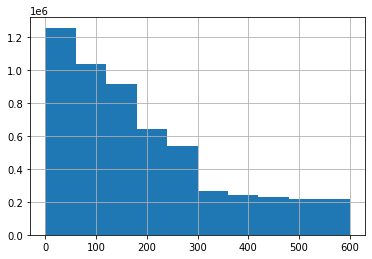

In [11]:
ds_final = ds_final[ds_final['Pres_Adj']< 600]
ds_final.Pres_Adj.hist()

In [12]:
# crear dataframes para cada mes a analizar, agrupar y sacar la media para evitar duplicados
lista_dfs=[]
for i in range(4): # 12
  if i ==0: # DJF
    mes_i= ds_final[(ds_final.Month ==12)|(ds_final.Month ==1)|(ds_final.Month ==2)]
    mes_i=mes_i[['Lon','Lat','Pres_Adj','Temp_Adj','Sal_Adj','Ciclo','Id']].groupby(by=['Lon','Lat','Ciclo','Pres_Adj','Id']).mean()
    mes_i=mes_i.reset_index()
    # Calculo de salinidad absoluta
    mes_i['SA']=gsw.SA_from_SP(SP=mes_i.Sal_Adj,p=mes_i.Pres_Adj, lon=mes_i.Lon,lat=mes_i.Lat)
    # Calculo Temperatura potencial
    mes_i['PT']=gsw.pt_from_t(SA=mes_i.SA.values, t= mes_i.Temp_Adj.values,p=mes_i.Pres_Adj.values,p_ref= 10.1325)
    # Calculo de Temperatura conservativa
    mes_i['CT']=gsw.CT_from_pt(SA= mes_i.SA,pt=mes_i.PT)
    # Calcular la densidad potencial
    mes_i['D']= gsw.density.rho(SA=mes_i.SA.values, CT=mes_i.CT.values,p= 10.25)-1000
    print('DJF: ', '- Dimension:',mes_i.shape)
    lista_dfs.append(mes_i)
  elif i ==1: # MAM
    mes_i= ds_final[(ds_final.Month ==3)|(ds_final.Month ==4)|(ds_final.Month ==5)]
    mes_i=mes_i[['Lon','Lat','Pres_Adj','Temp_Adj','Sal_Adj','Ciclo','Id']].groupby(by=['Lon','Lat','Ciclo','Pres_Adj','Id']).mean()
    mes_i=mes_i.reset_index()
    # Calculo de salinidad absoluta
    mes_i['SA']=gsw.SA_from_SP(SP=mes_i.Sal_Adj,p=mes_i.Pres_Adj, lon=mes_i.Lon,lat=mes_i.Lat)
    # Calculo Temperatura potencial
    mes_i['PT']=gsw.pt_from_t(SA=mes_i.SA.values, t= mes_i.Temp_Adj.values,p=mes_i.Pres_Adj.values,p_ref= 10.1325)
    # Calculo de Temperatura conservativa
    mes_i['CT']=gsw.CT_from_pt(SA= mes_i.SA,pt=mes_i.PT)
    # Calcular la densidad potencial
    mes_i['D']= gsw.density.rho(SA=mes_i.SA.values, CT=mes_i.CT.values,p= 10.25)-1000
    print('MAM: ', '- Dimension:',mes_i.shape)
    lista_dfs.append(mes_i)
  elif i ==2: # JJA
    mes_i= ds_final[(ds_final.Month ==6)|(ds_final.Month ==7)|(ds_final.Month ==8)]
    mes_i=mes_i[['Lon','Lat','Pres_Adj','Temp_Adj','Sal_Adj','Ciclo','Id']].groupby(by=['Lon','Lat','Ciclo','Pres_Adj','Id']).mean()
    mes_i=mes_i.reset_index()
    # Calculo de salinidad absoluta
    mes_i['SA']=gsw.SA_from_SP(SP=mes_i.Sal_Adj,p=mes_i.Pres_Adj, lon=mes_i.Lon,lat=mes_i.Lat)
    # Calculo Temperatura potencial
    mes_i['PT']=gsw.pt_from_t(SA=mes_i.SA.values, t= mes_i.Temp_Adj.values,p=mes_i.Pres_Adj.values,p_ref= 10.1325)
    # Calculo de Temperatura conservativa
    mes_i['CT']=gsw.CT_from_pt(SA= mes_i.SA,pt=mes_i.PT)
    # Calcular la densidad potencial
    mes_i['D']= gsw.density.rho(SA=mes_i.SA.values, CT=mes_i.CT.values,p= 10.25)-1000
    print('JJA: ', '- Dimension:',mes_i.shape)
    lista_dfs.append(mes_i)
  else: #SON
    mes_i= ds_final[(ds_final.Month ==9)|(ds_final.Month ==10)|(ds_final.Month ==11)]
    mes_i=mes_i[['Lon','Lat','Pres_Adj','Temp_Adj','Sal_Adj','Ciclo','Id']].groupby(by=['Lon','Lat','Ciclo','Pres_Adj','Id']).mean()
    mes_i=mes_i.reset_index()
    # Calculo de salinidad absoluta
    mes_i['SA']=gsw.SA_from_SP(SP=mes_i.Sal_Adj,p=mes_i.Pres_Adj, lon=mes_i.Lon,lat=mes_i.Lat)
    # Calculo Temperatura potencial
    mes_i['PT']=gsw.pt_from_t(SA=mes_i.SA.values, t= mes_i.Temp_Adj.values,p=mes_i.Pres_Adj.values,p_ref= 10.1325)
    # Calculo de Temperatura conservativa
    mes_i['CT']=gsw.CT_from_pt(SA= mes_i.SA,pt=mes_i.PT)
    # Calcular la densidad potencial
    mes_i['D']= gsw.density.rho(SA=mes_i.SA.values, CT=mes_i.CT.values,p= 10.25)-1000
    print('SON: ', '- Dimension:',mes_i.shape)
    lista_dfs.append(mes_i)
print(len(lista_dfs))

DJF:  - Dimension: (799172, 11)
MAM:  - Dimension: (834590, 11)
JJA:  - Dimension: (815068, 11)
SON:  - Dimension: (851529, 11)
4


In [13]:
# Funcion para sacar el numero de perfiles por cada mes
import numpy as np
import matplotlib.pyplot as plt
def cantidad_perfiles_mes(data):
  x = data.Lon;y = data.Lat;
  # Creacion de la grilla
  gridx = np.arange(-130,-110+1,1) # valores de lon
  #print(gridx.shape);print(gridx);
  gridy = np.arange(20,50+1,1)
  #print(gridy.shape);print(gridy);
  grid, _, _ = np.histogram2d(x, y, bins=[gridx, gridy]);
  #print(grid.shape)
  # Ponerlo en el mismo sentido para que quede alineado con Chile
  grid1=np.flip(grid.T, axis=0) # Izquierda°-85W , derecha -70°W, arriba -15°S, abajo -45°S
  x1= np.arange(-130+0.5, -110+0.5,1);y1= list(np.arange(20+0.5,50+0.5,1));y1=y1[::-1];y1= np.array(y1);
  #print(x1.shape);print(y1.shape)
  # Reemplazar 0 por nan
  grid1[grid1 == 0] = np.nan
  return grid1

In [14]:
lista_conteos=[]
for i in range(len(lista_dfs)):
  lista_conteos.append(cantidad_perfiles_mes(lista_dfs[i]))

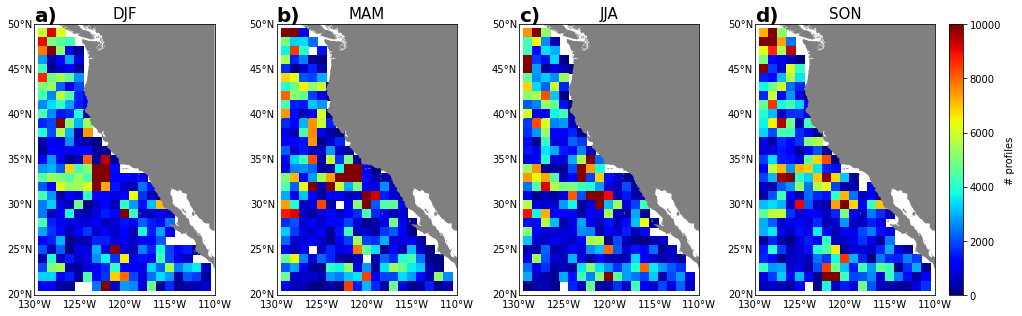

In [15]:
import string
ticks= np.array([0,2000, 4000, 6000, 8000, 10000]) #labels para el colorbar
x1= np.arange(-130+0.5, -110+0.5,1);y1= list(np.arange(20+0.5,50+0.5,1));y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.17
meses=['DJF','MAM','JJA','SON']
# atributos [left, bottom, width,height] en escala (0,1)
#list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
#        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
#        [0,0.4,w,h],[0.2,0.4,w,h],[0.4,0.4,w,h],[0.6,0.4,w,h],]
list_o =[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h]]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(len(lista_conteos))):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-130,llcrnrlat=20,urcrnrlon=-110,urcrnrlat=50, resolution ='h')
  x, y = m(x1, y1)
  z= lista_conteos[j]
  cmap= plt.get_cmap("jet")
  cs=m.pcolormesh(x1, y1, z,cmap='jet',shading='flat',latlon=True,vmin=0, vmax=10000)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(20,51,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-130,-125,-120,-115,-110],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('# profiles', rotation=90)

## Filtro si hay menos de 1000 perfiles

In [ ]:
lista_cont_fin=[]
for j in range(len(lista_conteos)):
  data= lista_conteos[j]
  data[data <1000]=np.nan
  lista_cont_fin.append(data)

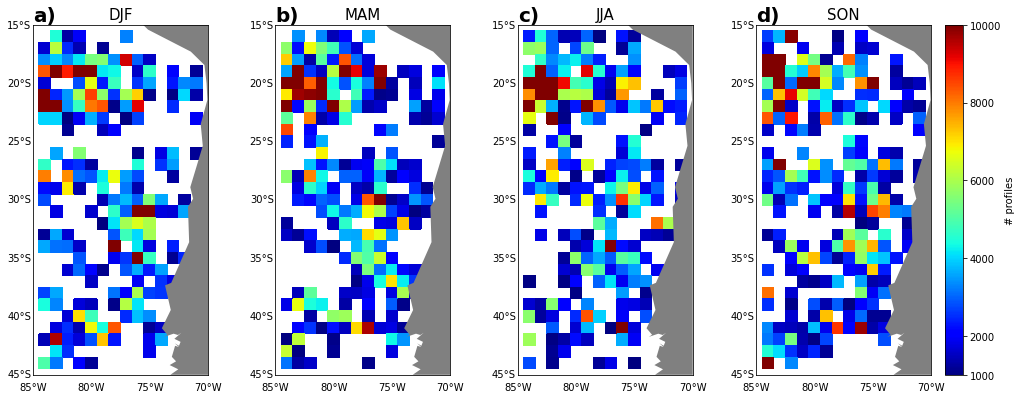

In [ ]:
import string
ticks= np.array([1000,2000, 4000, 6000, 8000, 10000]) #labels para el colorbar
x1= np.arange(-85+0.5, -70+0.5,1);y1= list(np.arange(-45+0.5,-15+0.5,1));y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.22
meses=['DJF','MAM','JJA','SON']
# atributos [left, bottom, width,height] en escala (0,1)
#list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
#        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
#        [0,0.4,w,h],[0.2,0.4,w,h],[0.4,0.4,w,h],[0.6,0.4,w,h],]
list_o =[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h]]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(len(lista_conteos))):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-85,llcrnrlat=-45,urcrnrlon=-70,urcrnrlat=-15, resolution ='c')
  x, y = m(x1, y1)
  z= lista_cont_fin[j]
  cmap= plt.get_cmap("jet")
  cs=m.pcolormesh(x1, y1, z,cmap='jet',shading='flat',latlon=True,vmin=1000, vmax=10000)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(-45,-14,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-85,-80,-75,-70],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('# profiles', rotation=90)

In [ ]:
# filtro DJF
DJF_filter= np.isnan(lista_cont_fin[0])
MAM_filter= np.isnan(lista_cont_fin[1])
JJA_filter= np.isnan(lista_cont_fin[2])
SON_filter= np.isnan(lista_cont_fin[3])

## Ejemplo de prueba para un mes (Interpolacion vertical Akima)

------------------------------------
Id : 3900224
Ciclo 144 ......................... Check
Ciclo 146 ......................... Check
Ciclo 147 ......................... Check
Ciclo 111 ......................... Check
Ciclo 148 ......................... Check
Ciclo 150 ......................... Check
Ciclo 149 ......................... Check
Ciclo 110 ......................... Check
Ciclo 109 ......................... Check
Ciclo 32 ......................... Check
Ciclo 31 ......................... Check
Ciclo 33 ......................... Check
Ciclo 34 ......................... Check
Ciclo 108 ......................... Check
Ciclo 30 ......................... Check
Ciclo 29 ......................... Check
Ciclo 188 ......................... Check
Ciclo 35 ......................... Check
Ciclo 28 ......................... Check
Ciclo 187 ......................... Check
Ciclo 27 ......................... Check
Ciclo 107 ......................... Check
Ciclo 186 .........................

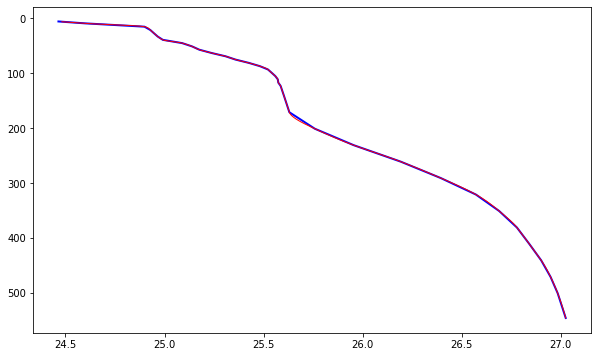

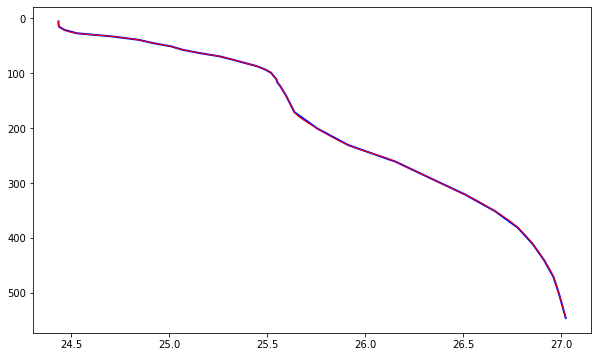

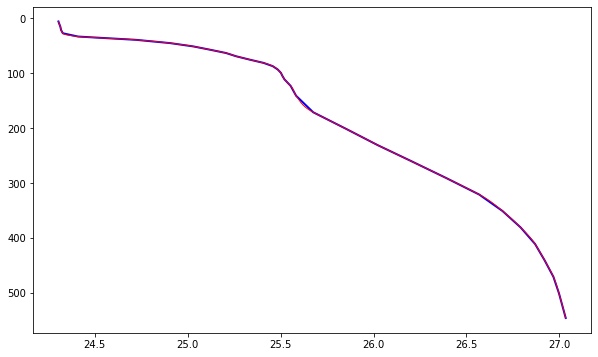

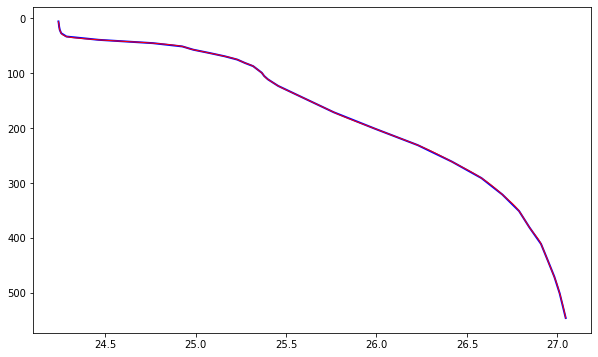

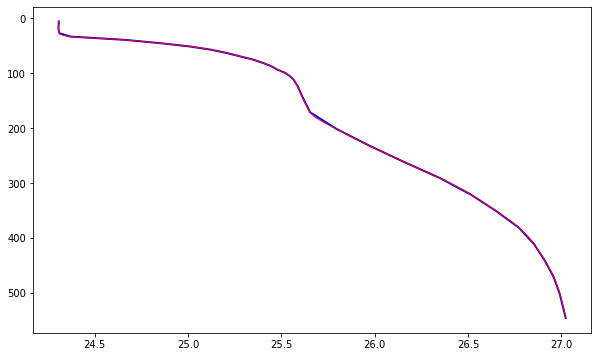

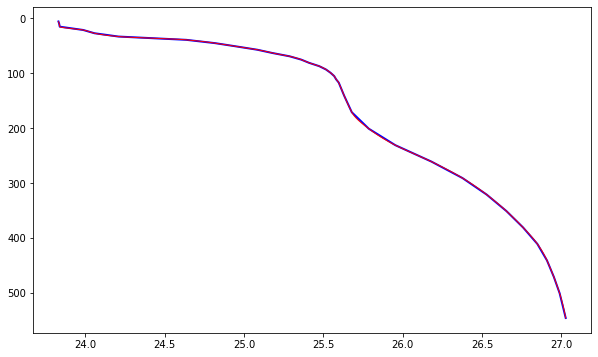

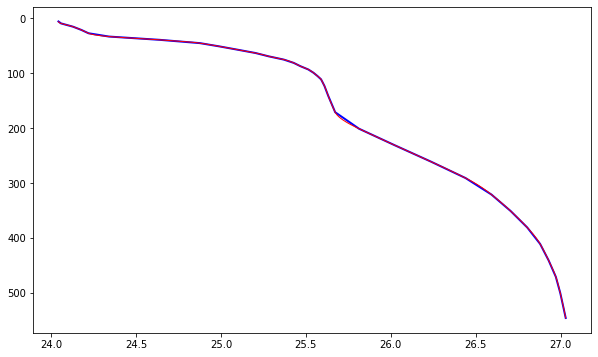

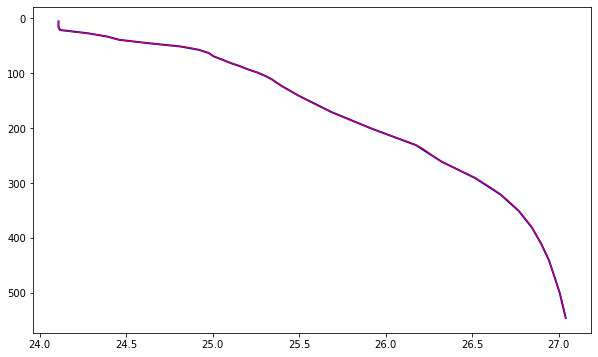

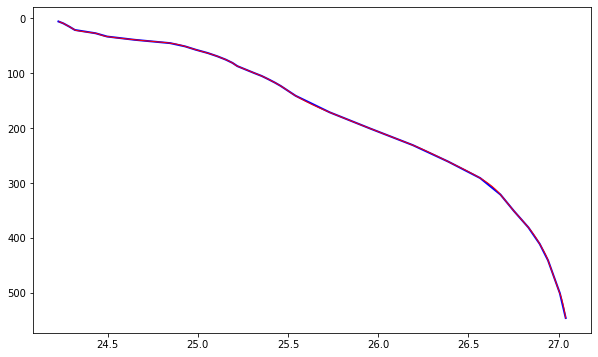

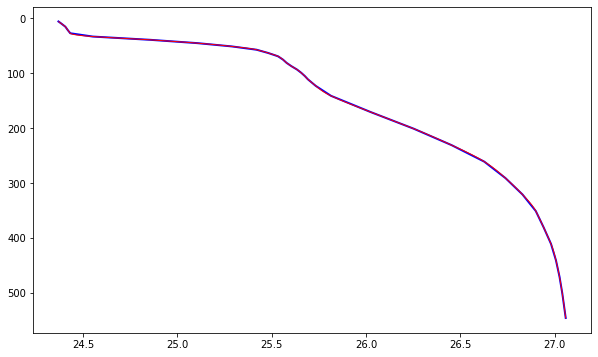

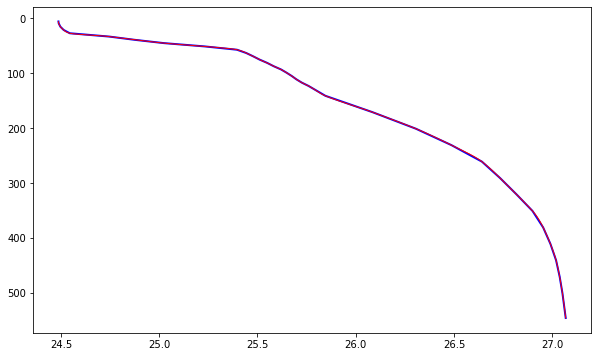

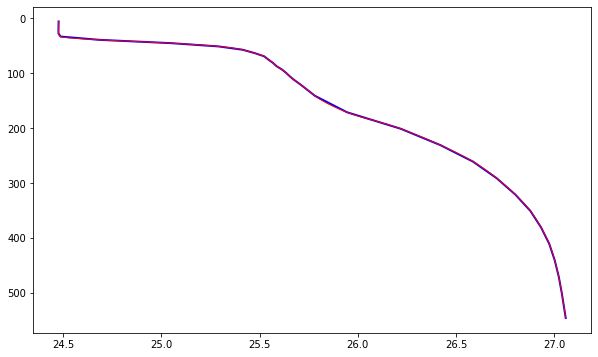

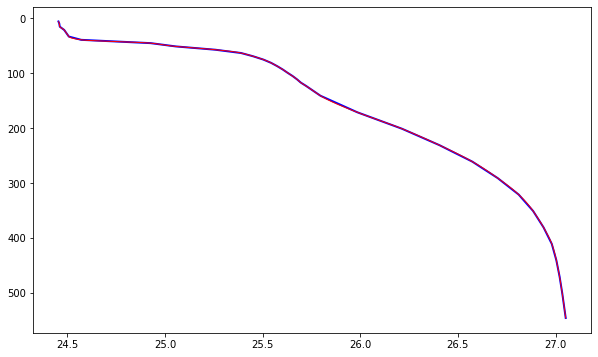

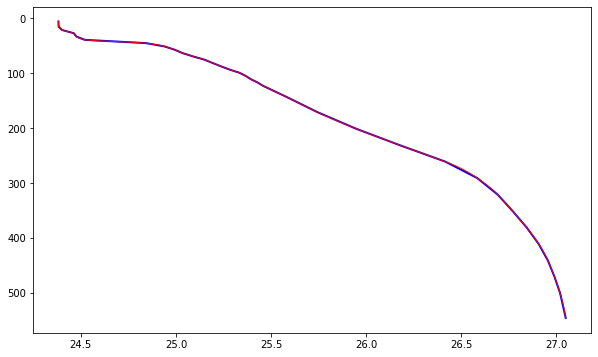

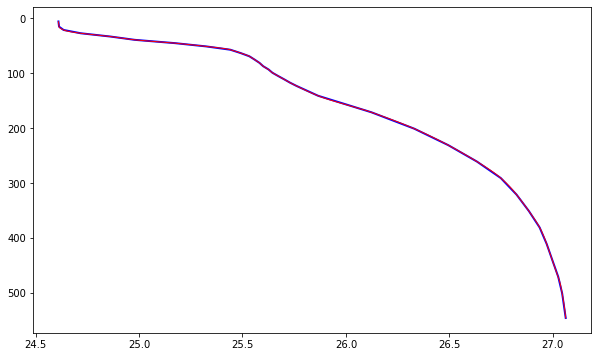

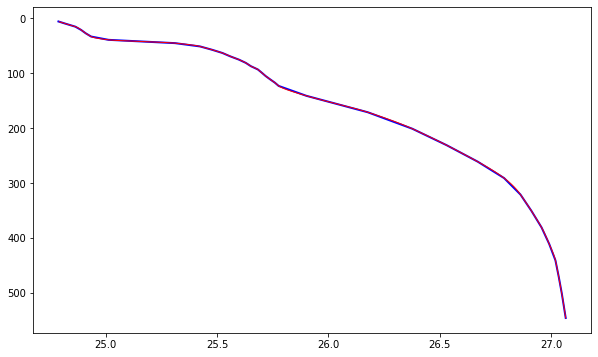

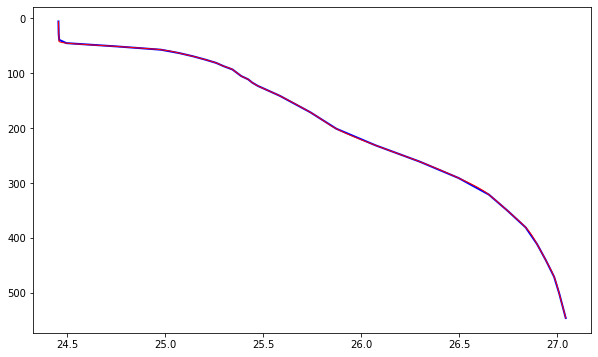

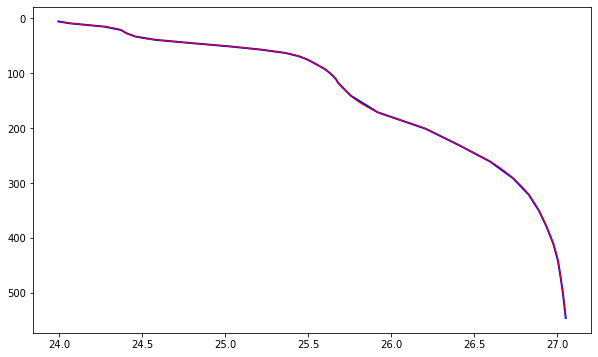

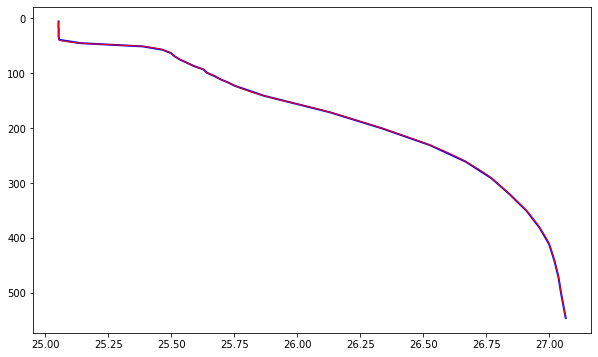

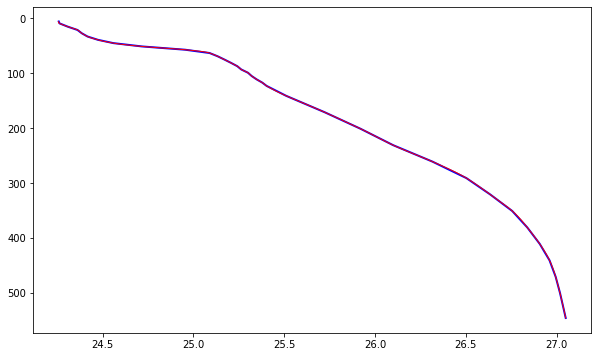

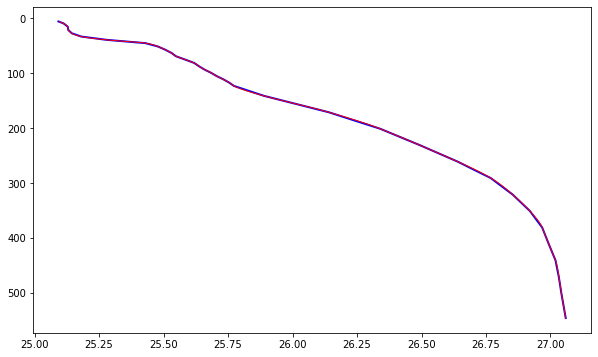

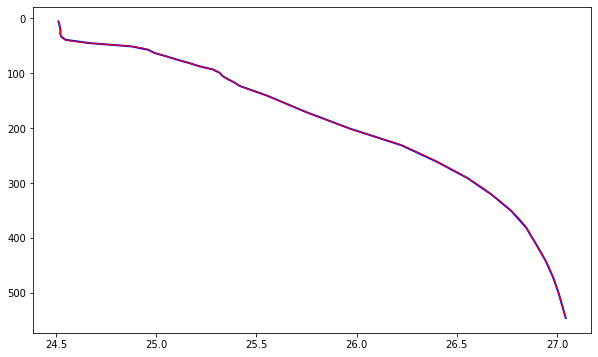

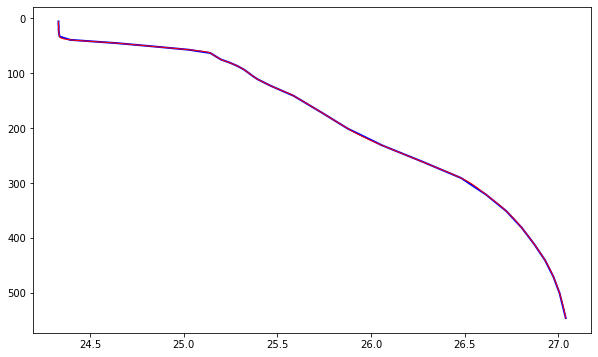

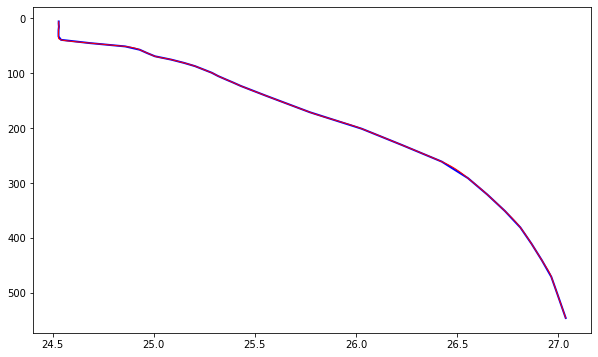

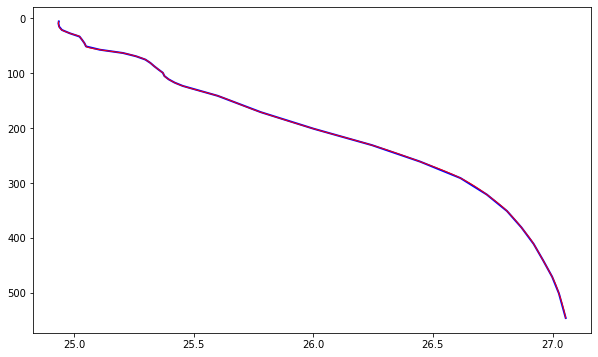

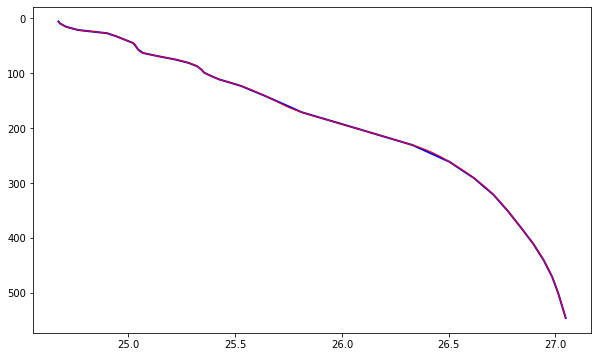

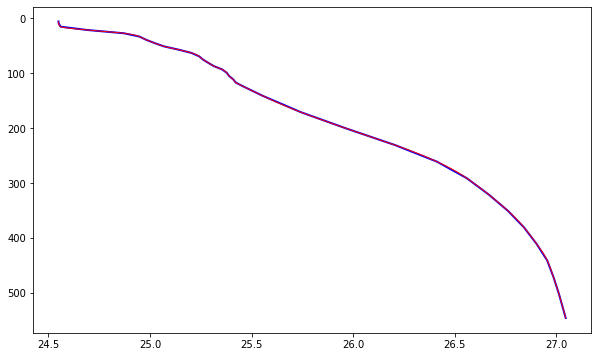

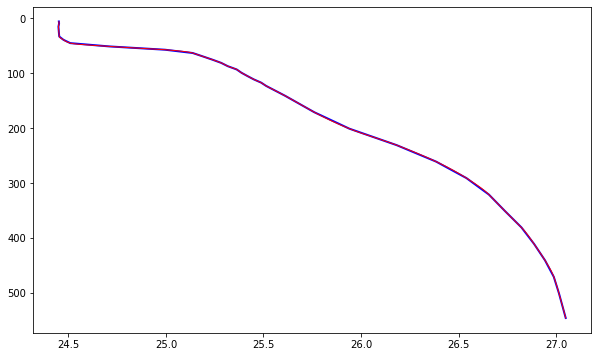

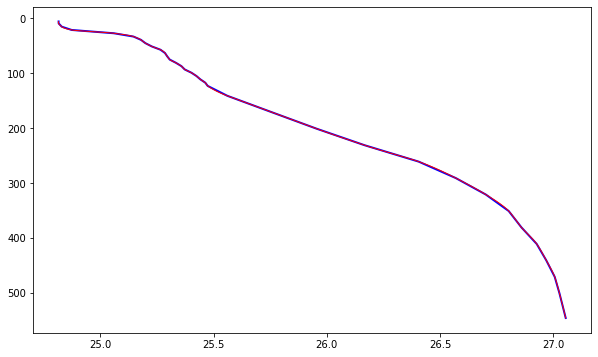

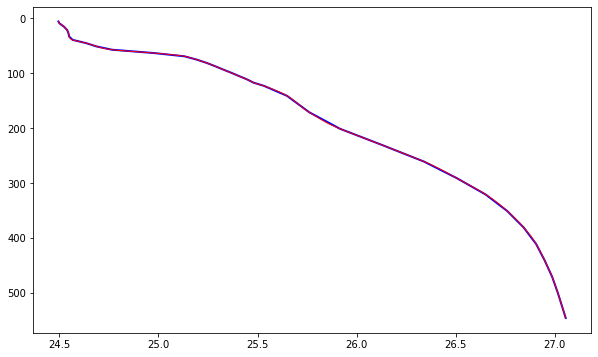

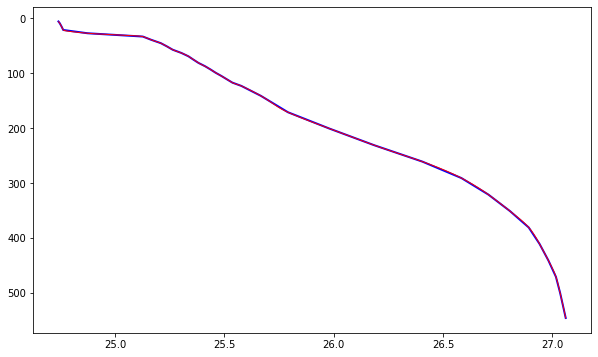

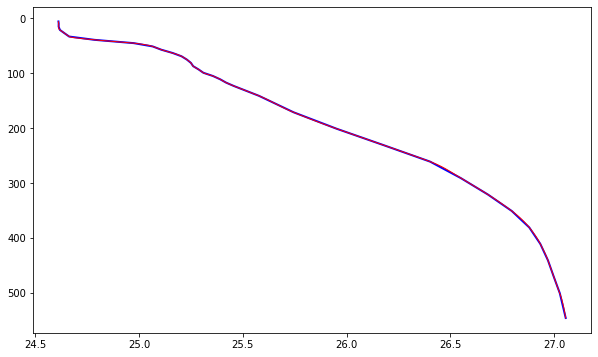

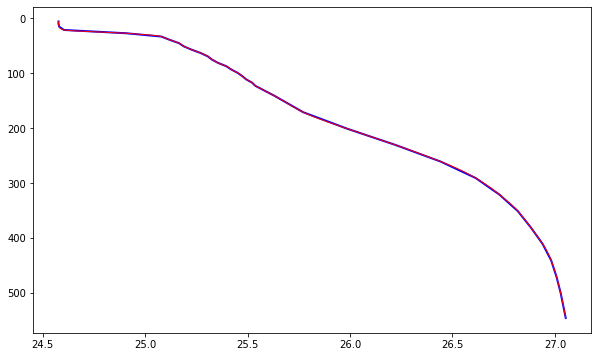

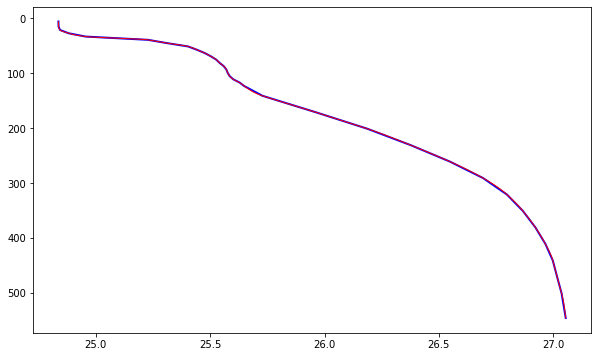

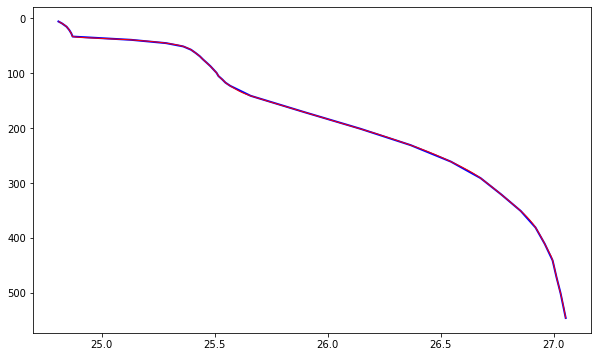

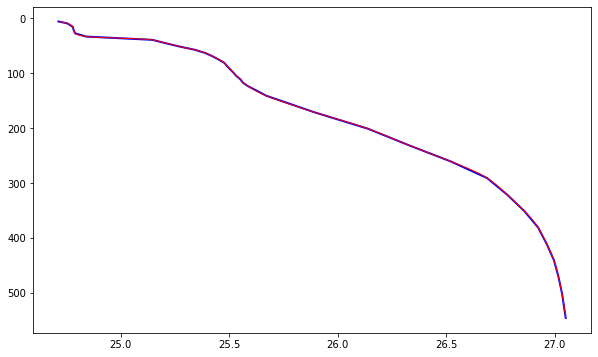

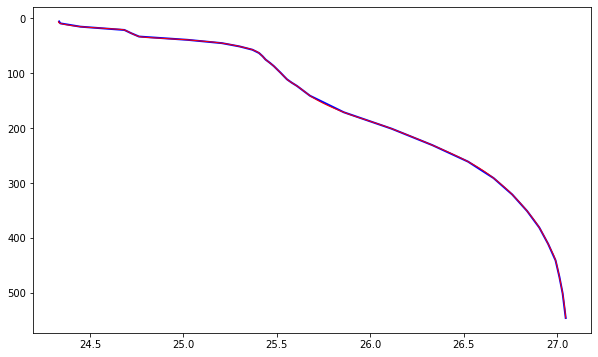

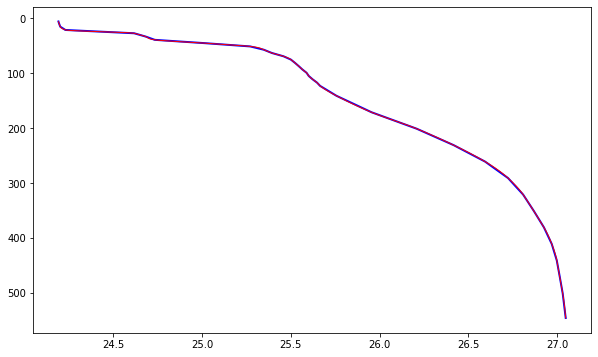

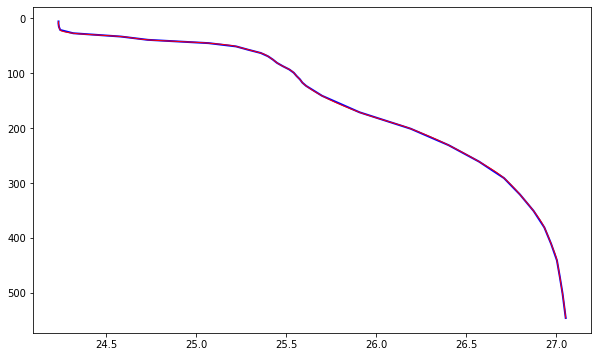

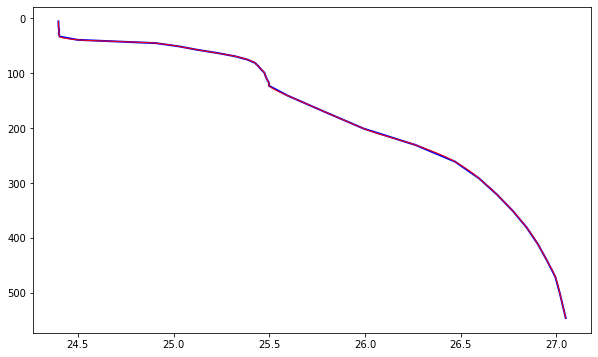

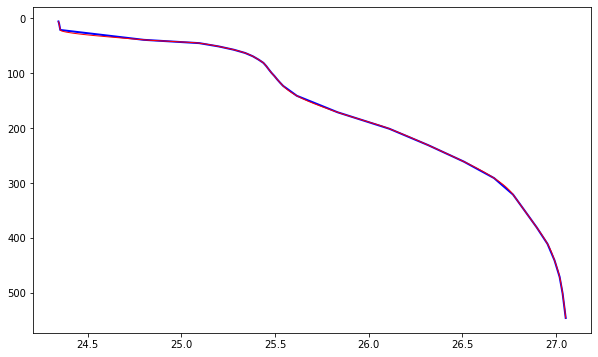

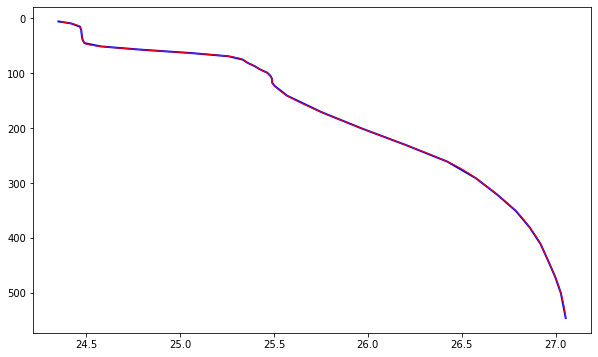

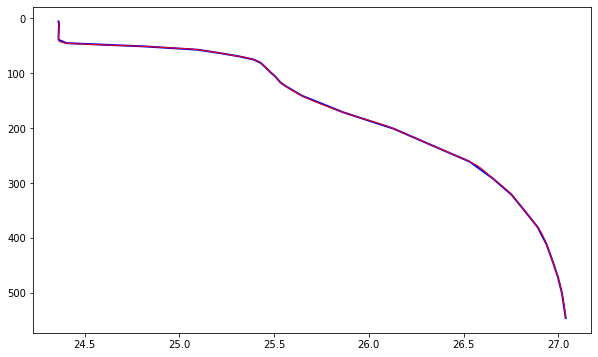

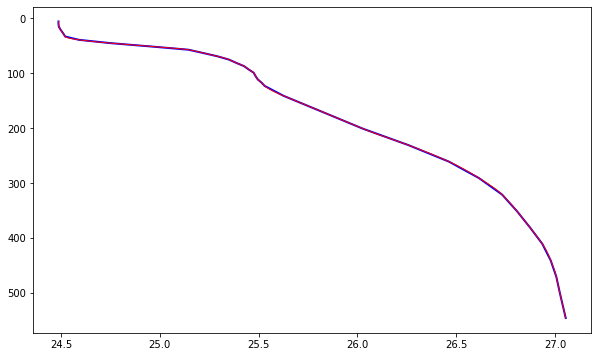

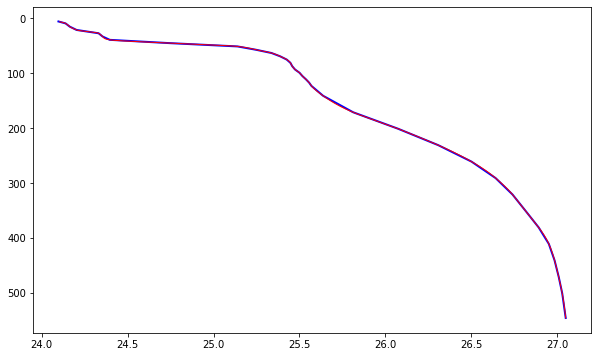

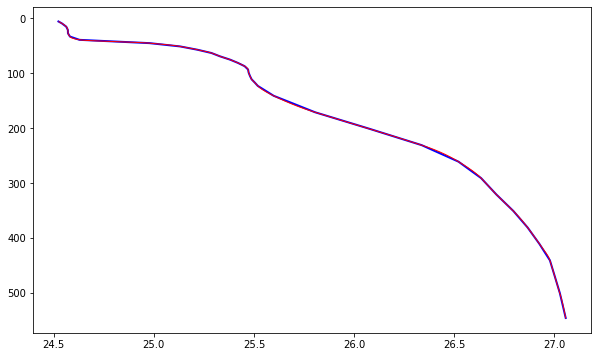

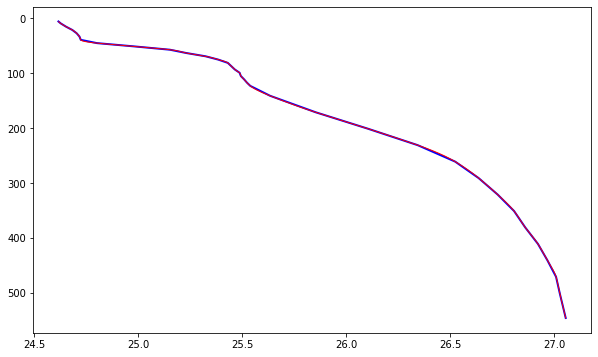

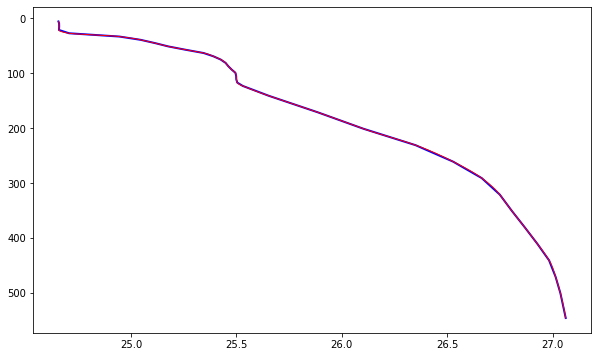

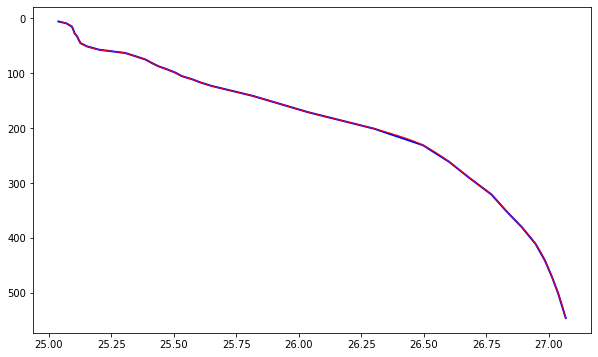

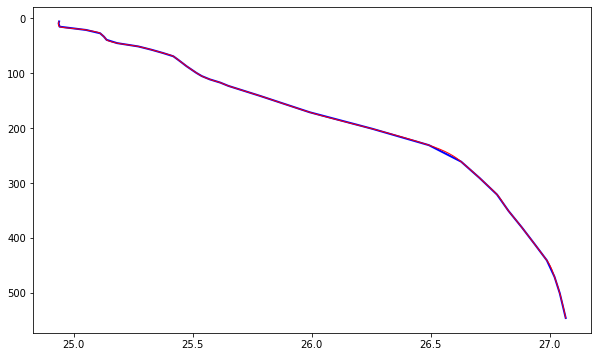

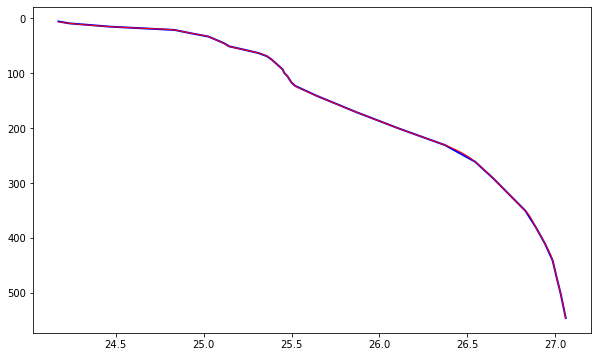

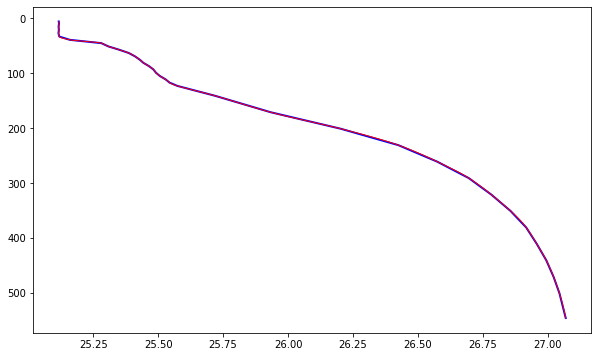

In [ ]:
import scipy.interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import Akima1DInterpolator
import math
import warnings
from itertools import repeat
warnings.filterwarnings("ignore") # Ignorar warnings
enero= lista_dfs[0]
############################################################################################################33
ids= list(enero.Id.unique()) # Ids unicos del dataframe
ciclos= list(enero.Ciclo.unique()) # ciclos unicos del dataframe
dfs= [] # Lista donde voy a almacener cada uno de los dataframes resultantes de la interpolacion
# Creacion de ciclo for para hacer interpolacion
for i in ids[0:1]: # Iterar solo el primer elemento (al final seria 0:len(ids))
  print('------------------------------------')
  print('Id :',i)
  #print('Ciclos disponibles:', ds_3D_m[ds_3D_m['Id']==i].Ciclo.unique()) # Solo para ver los ciclos del primer id
  ciclos=enero[enero['Id']==i].Ciclo.unique()
  for j in ciclos:
    print('Ciclo',j,'......................... Check')
    # Filtro del id y ciclo respectivo
    ds= enero[(enero['Id']==i) & (enero['Ciclo']==j)] # Variable local (se sobre escribe cada vez)
    # Hacer el subset entre 0 y 2000 dbar para que no haya problemas de consistencia
    ds= ds[(ds['Pres_Adj']>=0) &(ds['Pres_Adj']<=600)] # Importante para que todos los valores queden entre 0 y 2000 dbar
    #print(ds) # Si se quiere ver el dataframe original
    # Extraer presion, temperatura y salinidad
    pres= ds.Pres_Adj; D= ds.D; # Variables locales otra vez
    # Objetos interpoladores de Salinidad y Temperatura
    # Caso 1: Spline (Espero que de mejor)
    spline_D= Akima1DInterpolator(pres,D) # Mejor metodo que encontre
    # Ahora se hace la interpolacion entre el rango de valores de presion:
    min_pres= math.floor(np.min(pres));max_pres= math.ceil(np.max(pres))
    # Crear la secuencia de valores entre el minimo y maximo encontrado en el perfil para interpolar
    pres_new= np.arange(min_pres,max_pres+1,1)
    # Interpolar T y S con (Metodo: Splines)
    D_new=spline_D(pres_new)
    #################################################################
    # Nueva grafica
    plt.figure(figsize=(10,6))
    plt.plot(ds.D,ds.Pres_Adj,color='b',linewidth=2)
    plt.plot(D_new,pres_new,color='r',linewidth=1)
    plt.gca().invert_yaxis()
    #################################################################
     # Crear el dataframe para cada perfil
    df_ts=pd.DataFrame();
    # Agregar lat y lon, id y ciclo automatica
    lat_0=ds.Lat.reset_index(drop=True);lon_0=ds.Lon.reset_index(drop=True);id_0=ds.Id.reset_index(drop=True);ciclo_0=ds.Ciclo.reset_index(drop=True)  
    # Valores de 0 a 2000 dbar espaciados cada 1 dbar
    df_ts['Presion_interp']=np.arange(0,600+1,1)
    df_ts['Lon']= np.repeat(lon_0[0],601);df_ts['Lat']= np.repeat(lat_0[0],601)
    df_ts['Id']= np.repeat(id_0[0],601);df_ts['Ciclo']= np.repeat(ciclo_0[0],601);
    df_ts['D_interp']=np.nan; df_ts['D_interp'][min_pres:max_pres+1]= D_new;
    #print(df_ts)
    # Concatenar todos los dataframes en dfs
    dfs.append(df_ts)

## Creacion de funcion para generalizar

In [16]:
import scipy.interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import Akima1DInterpolator
import math
import warnings
from itertools import repeat
warnings.filterwarnings("ignore") # Ignorar warnings
def interpolador_capas(dataframe, max_depth, intervalo):
  '''
  dataframe= pandas dataframe con columnas Lon, Lat,ciclo, Pres_adj, Id, Variable
  max_depth= valor entero de profundidad maxima a interpolar
  intervalo= intervalo de profundidad en m para interpolacion
  '''
  # Enfocarme en estas profundidades
  lista_prof = list(np.arange(0,max_depth+1,intervalo)) # Intervalos de 5m para extraer capas
  ############################################################################################################33
  ds_3D_m=dataframe
  ids= list(ds_3D_m.Id.unique()) # Ids unicos del dataframe
  ciclos= list(ds_3D_m.Ciclo.unique()) # ciclos unicos del dataframe
  dfs= [] # Lista donde voy a almacener cada uno de los dataframes resultantes de la interpolacion
  for i in ids: 
    # Iterar solo el primer elemento (al final seria 0:len(ids))
    #print('------------------------------------')
    #print('Id :',i,'................... Check')
    #print('Ciclos disponibles:', ds_3D_m[ds_3D_m['Id']==i].Ciclo.unique()) # Solo para ver los ciclos del primer id
    ciclos=ds_3D_m[ds_3D_m['Id']==i].Ciclo.unique()
    for j in ciclos:
      #print('Ciclo',j,'......................... Check')
      # Filtro del id y ciclo respectivo
      ds= ds_3D_m[(ds_3D_m['Id']==i) & (ds_3D_m['Ciclo']==j)] # Variable local (se sobre escribe cada vez)
      # Hacer el subset entre 0 y 2000 dbar para que no haya problemas de consistencia
      ds= ds[(ds['Pres_Adj']>=0) &(ds['Pres_Adj']<=max_depth)] # Importante para que todos los valores queden entre 0 y 2000 dbar
      # Extraer presion, temperatura y salinidad
      pres= ds.Pres_Adj;D= ds.D;T=ds.Temp_Adj;S=ds.Sal_Adj # Variables locales otra vez
      # Objetos interpoladores de Salinidad y Temperatura
      # Caso 1: Spline (Espero que de mejor)
      try:
        spline_D= Akima1DInterpolator(pres,D) # Mejor metodo que encontre
        spline_T= Akima1DInterpolator(pres,T) # Mejor metodo que encontre
        spline_S= Akima1DInterpolator(pres,S) # Mejor metodo que encontre
        # Ahora se hace la interpolacion entre el rango de valores de presion:
        min_pres= math.floor(np.min(pres));max_pres= math.ceil(np.max(pres))
        # Crear la secuencia de valores entre el minimo y maximo encontrado en el perfil para interpolar
        pres_new= np.arange(min_pres,max_pres+1,1)
        D_new=spline_D(pres_new)# Interpolar T y S con (Metodo: Splines)
        T_new=spline_T(pres_new)# Interpolar T y S con (Metodo: Splines)
        S_new=spline_S(pres_new)# Interpolar T y S con (Metodo: Splines)
        df_ts=pd.DataFrame();# Crear el dataframe para cada perfil
        # Agregar lat y lon, id y ciclo automatica
        lat_0=ds.Lat.reset_index(drop=True);lon_0=ds.Lon.reset_index(drop=True);id_0=ds.Id.reset_index(drop=True);ciclo_0=ds.Ciclo.reset_index(drop=True)  
        df_ts['Presion_interp']=np.arange(0,max_depth+1,1)
        df_ts['Lon']= np.repeat(lon_0[0],max_depth+1);df_ts['Lat']= np.repeat(lat_0[0],max_depth+1)
        df_ts['Id']= np.repeat(id_0[0],max_depth+1);df_ts['Ciclo']= np.repeat(ciclo_0[0],max_depth+1);
        df_ts['D_interp']=np.nan;df_ts['D_interp'][min_pres:max_pres+1]= D_new;
        df_ts['T_interp']=np.nan;df_ts['T_interp'][min_pres:max_pres+1]= T_new;
        df_ts['S_interp']=np.nan;df_ts['S_interp'][min_pres:max_pres+1]= S_new;
        # Hacer el subset a las profundidades deseadas
        df_ts= df_ts[df_ts['Presion_interp'].isin(lista_prof)]
        dfs.append(df_ts)# Concatenar todos los dataframes en dfs
      except:
        #print('Intento fallido en Id:',i, 'Ciclo',j)
        pass
  # Interpolar para llenar la capa superficial
  dfs_final=[]
  for i in dfs:
    try:
      data_f= i.interpolate(method='spline', order=1,limit_direction='backward')
      dfs_final.append(data_f)# Agregar los dataframes
    except:
      dfs_final.append(i)
  print('Tamaño de los dataframes generados :',len(dfs_final))
  df_final= pd.concat(dfs_final)
  # Agrupar por cada Lat, Lon y Presion sacando la media que no tiene en cuenta los nan
  df_final=df_final[['Presion_interp','Lon','Lat','D_interp','T_interp','S_interp']].groupby(by=['Lon','Lat','Presion_interp']).mean().reset_index()
  print(df_final.shape)
  return df_final

## Validacion-DJF

In [17]:
DJF= interpolador_capas(dataframe= lista_dfs[0], max_depth= 600, intervalo=1)
DJF

Tamaño de los dataframes generados : 6026
(3621626, 6)


Lon       Lat  Presion_interp   D_interp   T_interp   S_interp
0       -129.9970  28.15200               0  24.559170  20.843927  34.178860
1       -129.9970  28.15200               1  24.564169  20.803558  34.178542
2       -129.9970  28.15200               2  24.569168  20.763189  34.178225
3       -129.9970  28.15200               3  24.574168  20.722821  34.177908
4       -129.9970  28.15200               4  24.579167  20.682452  34.177590
...           ...       ...             ...        ...        ...        ...
3621621 -110.0088  21.95483             596  27.052365   7.285000  34.505000
3621622 -110.0088  21.95483             597  27.052899   7.283665  34.505400
3621623 -110.0088  21.95483             598  27.053440   7.282985  34.505944
3621624 -110.0088  21.95483             599        NaN        NaN        NaN
3621625 -110.0088  21.95483             600        NaN        NaN        NaN

[3621626 rows x 6 columns]

In [18]:
import scipy
from scipy.interpolate import griddata
ds_final= DJF #pasar los resultados del dataframe anteriores
# Lista para ir guardando cada matrix latxlon
datos_jan_D = []
datos_jan_T = []
datos_jan_S = []
for i in ds_final.Presion_interp.unique()[:-1]: # voy de 5m en adelante
  capa_x=ds_final[ds_final['Presion_interp']==i]
  # Grilla generica
  gridx = np.arange(-130+0.5,-110+0.5,1)# np.arange(-85,-70+1,1)
  gridy = np.arange(20+0.5, 50+0.5,1)#np.arange(-45, -15+1,1)
  grid_x, grid_y =scipy.meshgrid(gridx,gridy)
  points =np.array(capa_x[['Lon','Lat']])
  values_D=np.array(capa_x['D_interp'])
  values_T=np.array(capa_x['T_interp'])
  values_S=np.array(capa_x['S_interp'])
  # Interpoladores
  grid_z0_D=griddata(points,values_D, (grid_x,grid_y),method='linear')
  grid_z0_T=griddata(points,values_T, (grid_x,grid_y),method='linear')
  grid_z0_S=griddata(points,values_S, (grid_x,grid_y),method='linear')
  # Rotacion en el eje y Sur-Norte
  grid_z0_1_D=np.flip(grid_z0_D, axis=0)
  grid_z0_1_T=np.flip(grid_z0_T, axis=0)
  grid_z0_1_S=np.flip(grid_z0_S, axis=0)
  #print(grid_z0_1.shape)# Esto no es necesario despues
  datos_jan_D.append(grid_z0_1_D);datos_jan_T.append(grid_z0_1_T);datos_jan_S.append(grid_z0_1_S)
datos_D = np.stack(datos_jan_D);datos_T = np.stack(datos_jan_T);datos_S = np.stack(datos_jan_S)

In [19]:
print(datos_D.shape,datos_T.shape,datos_S.shape)

(600, 30, 20) (600, 30, 20) (600, 30, 20)


In [20]:
# Modelo data
T_DJF=np.mean(reanal.where(((reanal.month==1)|(reanal.month==2)|(reanal.month==12)), drop=True).CT.values,axis=0)
S_DJF=np.mean(reanal.where(((reanal.month==1)|(reanal.month==2)|(reanal.month==12)), drop=True).SA.values,axis=0)
D_DJF=np.mean(reanal.where(((reanal.month==1)|(reanal.month==2)|(reanal.month==12)), drop=True).D.values,axis=0)
print(T_DJF.shape, S_DJF.shape, D_DJF.shape)

(40, 121, 81) (40, 121, 81) (40, 121, 81)


In [21]:
# Interpolar a todas las capas para la misma grilla
x1= np.arange(-130+0.5, -110+0.5,1)
y1= list(np.arange(20+0.5, 50+0.5,1));y1=y1[::-1];y1= np.array(y1)
X_t, Y_t= np.meshgrid(x1,y1)
dat_D = []
dat_T = []
dat_S = []
for i in range(T_DJF.shape[0]):
  T_X=basemap.interp(datain=np.flipud(T_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  D_X=basemap.interp(datain=np.flipud(D_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  S_X=basemap.interp(datain=np.flipud(S_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  dat_D.append(D_X);dat_T.append(T_X);dat_S.append(S_X)
M_D = np.stack(dat_D);M_T = np.stack(dat_T);M_S = np.stack(dat_S)
print(M_D.shape, M_T.shape, M_S.shape)

(40, 30, 20) (40, 30, 20) (40, 30, 20)


<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -129.5 -128.5 -127.5 -126.5 ... -112.5 -111.5 -110.5
  * lat      (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 21.99 21.95 21.88 21.84 ... nan nan nan
    S        (depth, lat, lon) float64 34.9 34.88 34.86 34.84 ... nan nan nan
    D        (depth, lat, lon) float64 24.06 24.06 24.07 24.06 ... nan nan nan

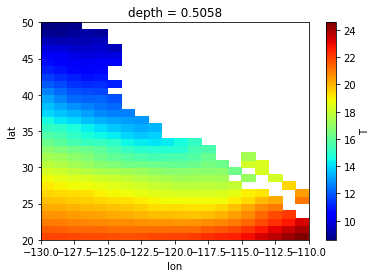

In [22]:
M_final=dt=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],M_T),"S":(['depth',"lat","lon"],M_S),"D":(['depth',"lat","lon"],M_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.arange(20+0.5, 50+0.5,1), 
                        "depth": reanal.depth.values})
M_final.T.sel(depth=M_final.depth.values[0]).plot(cmap='jet')
M_final

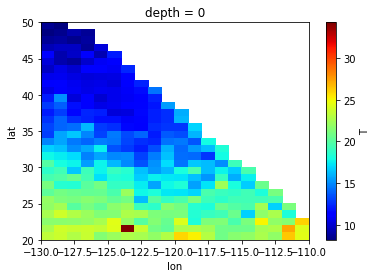

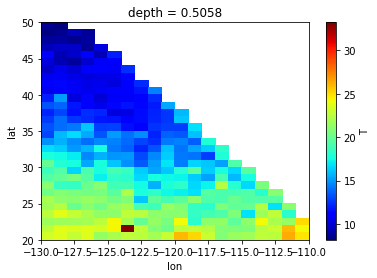

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -129.5 -128.5 -127.5 -126.5 ... -112.5 -111.5 -110.5
  * lat      (lat) float64 49.5 48.5 47.5 46.5 45.5 ... 24.5 23.5 22.5 21.5 20.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 8.66 8.202 nan nan ... 7.682 7.675 7.923
    S        (depth, lat, lon) float64 32.95 32.89 nan nan ... 34.53 34.51 34.54
    D        (depth, lat, lon) float64 25.62 25.64 nan nan ... 27.01 27.0 26.99

In [23]:
A_no_interp=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.array(list(np.arange(20+0.5, 50+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)})
A_final=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.array(list(np.arange(20+0.5, 50+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)}).interp(depth=reanal.depth.values)
A_no_interp.T.sel(depth=A_no_interp.depth.values[0]).plot(cmap='jet')
plt.show()
A_final.T.sel(depth=A_final.depth.values[0]).plot(cmap='jet')
plt.show()
A_final

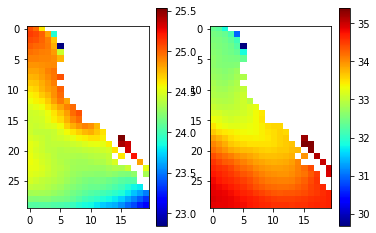

In [ ]:
plt.subplot(121)
plt.imshow(np.flipud(M_D[0,:,:]),cmap='jet')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.flipud(M_S[0,:,:]),cmap='jet')
plt.colorbar()
#plt.subplot(133)
#plt.imshow(np.flipud(M_S[0,:,:]),cmap='jet')
#plt.colorbar()

### Graficos transectas pruebas

In [ ]:
X_t[0]

array([-129.5, -128.5, -127.5, -126.5, -125.5, -124.5, -123.5, -122.5,
       -121.5, -120.5, -119.5, -118.5, -117.5, -116.5, -115.5, -114.5,
       -113.5, -112.5, -111.5, -110.5])

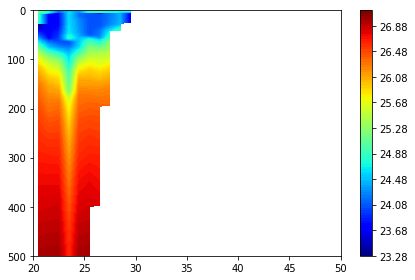

In [ ]:
prof= np.arange(0,600,1) # profundidades 
xts1=X_t[0,:]
yt1=Y_t[:,0]
tran_lat1=datos_D[:,:,-5]# 0:-84.5 , 1: -83.5 ,......
plt.contourf(yt1,prof, tran_lat1,cmap='jet',levels=100)
#plt.contour(yt1,prof, tran_lat1,cmap='jet',levels=100)
plt.colorbar()
plt.ylim([0,500])
plt.xlim([20,50])
plt.tight_layout()
plt.margins(x=0)
plt.gca().invert_yaxis()

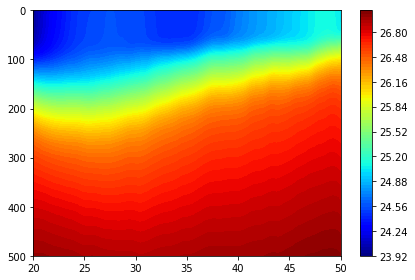

In [ ]:
D_M=reanal.D.sel(lon=-129.5).where((reanal.month==1)|(reanal.month==2)|(reanal.month==12), drop=True).mean('month').values
prof_M= reanal.depth.values # profundidades 
plt.contourf(reanal.lat.values,prof_M,D_M,cmap='jet',levels=100)
#plt.contour(yt1,prof, tran_lat1,cmap='jet',levels=100)
plt.colorbar()
plt.ylim([0,500])
plt.xlim([20,50])
plt.tight_layout()
plt.margins(x=0)
plt.gca().invert_yaxis()

In [ ]:
Y_t[:,0]

array([49.5, 48.5, 47.5, 46.5, 45.5, 44.5, 43.5, 42.5, 41.5, 40.5, 39.5,
       38.5, 37.5, 36.5, 35.5, 34.5, 33.5, 32.5, 31.5, 30.5, 29.5, 28.5,
       27.5, 26.5, 25.5, 24.5, 23.5, 22.5, 21.5, 20.5])

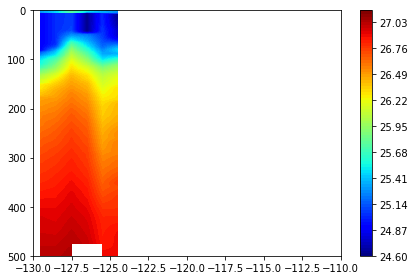

In [ ]:
tran_lat2=datos_D[:,5,:]# 0:-15.5 , 1: -16.5 ,......
plt.contourf(xts1,prof, tran_lat2,cmap='jet',levels=100)
#plt.contour(yt1,prof, tran_lat1,cmap='jet',levels=100)
plt.colorbar()
plt.ylim([0,500])
plt.xlim([-130,-110])
plt.tight_layout()
plt.margins(x=0)
plt.gca().invert_yaxis()

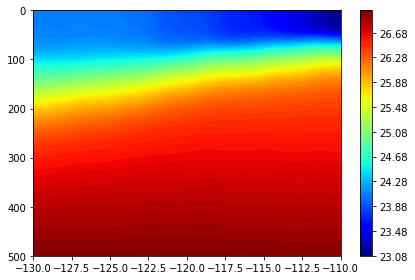

In [ ]:
D_M=reanal.D.sel(lat=20.5).where((reanal.month==1)|(reanal.month==2)|(reanal.month==12), drop=True).mean('month').values
prof_M= reanal.depth.values # profundidades 
plt.contourf(reanal.lon.values,prof_M,D_M,cmap='jet',levels=100)
#plt.contour(yt1,prof, tran_lat1,cmap='jet',levels=100)
plt.colorbar()
plt.ylim([0,500])
plt.xlim([-130,-110])
plt.tight_layout()
plt.margins(x=0)
plt.gca().invert_yaxis()

### Graficas finales transectas

### Latitudinales

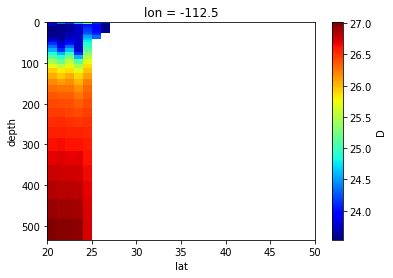

In [43]:
A_final.sel(lon=-112.5).D.plot(cmap='jet')
plt.gca().invert_yaxis()

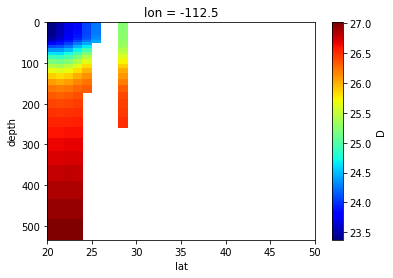

In [44]:
M_final.sel(lon=-112.5).D.plot(cmap='jet')
plt.gca().invert_yaxis()

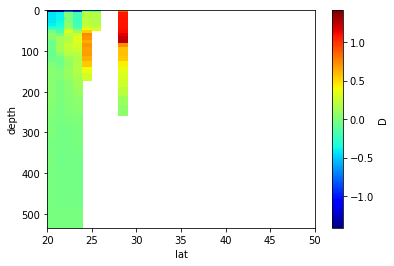

In [45]:
(M_final.sel(lon=-112.5).D-A_final.sel(lon=-116.5).D).plot(cmap='jet')
plt.gca().invert_yaxis()

In [24]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lon_Y= [-128.5,-122.5,-116.5,-112.5]
for i in range(4):
  tran_lat_d=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_s=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_t=A_final.sel(lon=lon_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lon=lon_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lon=lon_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lon=lon_Y[i]).T.values
  tran_lat_dx=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_sx=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_tx=A_final.sel(lon=lon_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(np.flip(tran_lat_M_d,axis=1));lista_ARGOX_LAT_D.append(np.flip((M_final.sel(lon=lon_Y[i]).D-A_final.sel(lon=lon_Y[i]).D).values,axis=1))
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(np.flip(tran_lat_M_s,axis=1));lista_ARGOX_LAT_S.append(np.flip((M_final.sel(lon=lon_Y[i]).S-A_final.sel(lon=lon_Y[i]).S).values,axis=1))
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(np.flip(tran_lat_M_t,axis=1));lista_ARGOX_LAT_T.append(np.flip((M_final.sel(lon=lon_Y[i]).T-A_final.sel(lon=lon_Y[i]).T).values,axis=1))
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

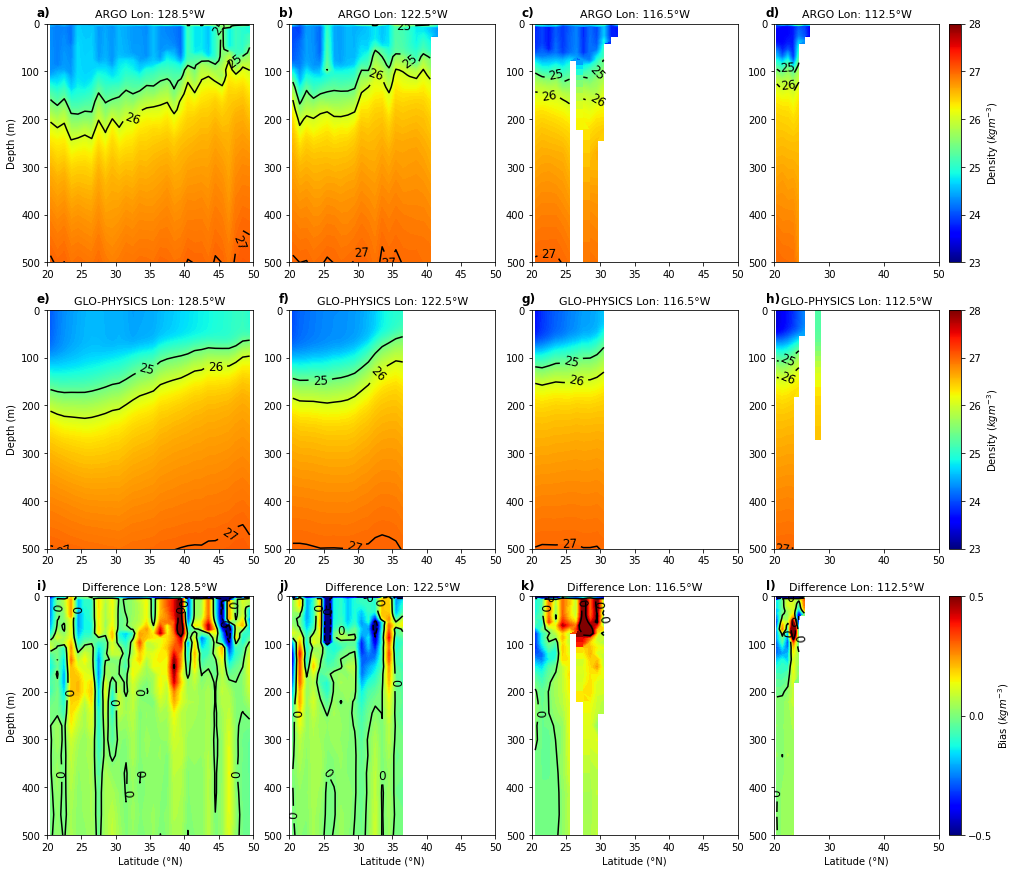

In [27]:
import string
vmins= [23]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [28]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[-0.5,0,0.5]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

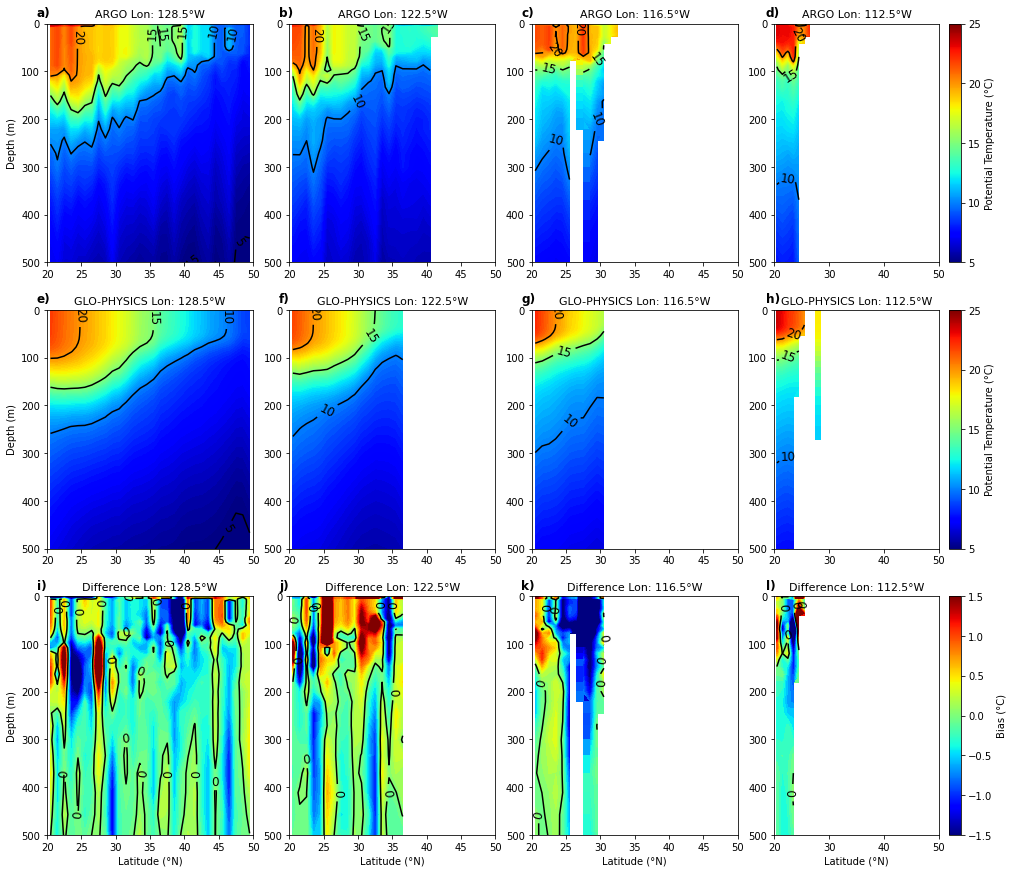

In [46]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

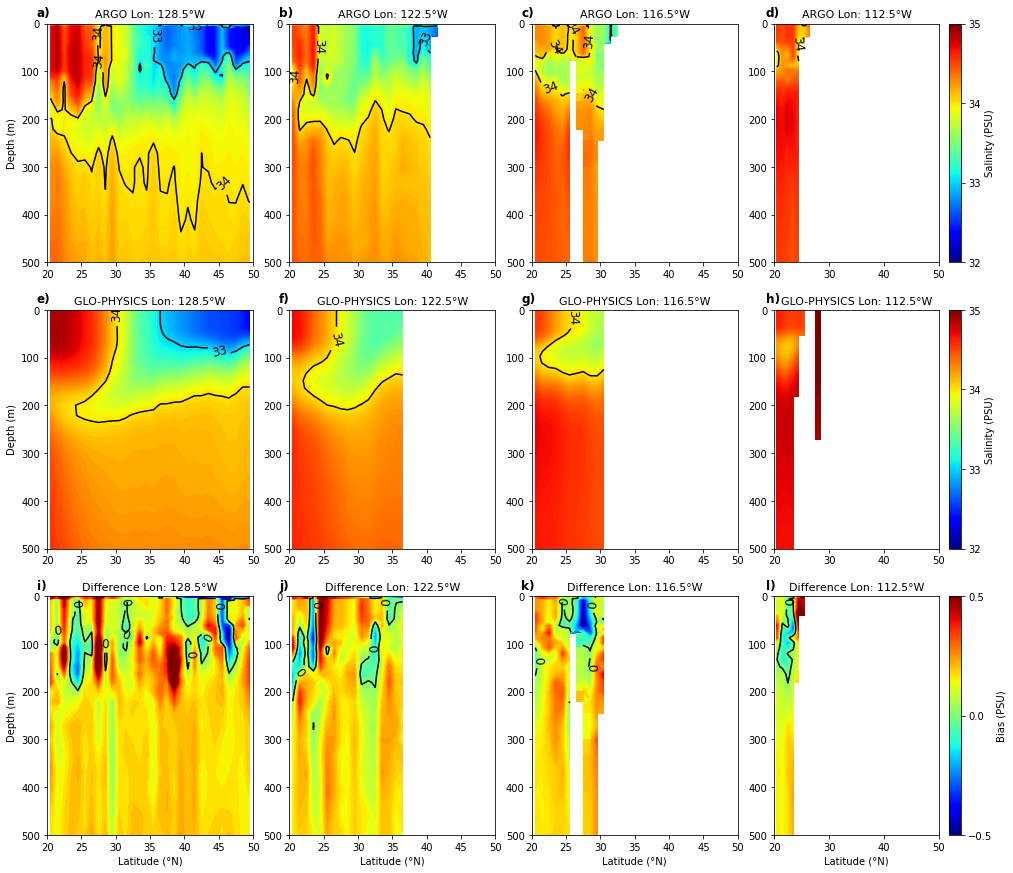

In [48]:
import string
vmins= [32]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [35]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[33,34,35,36]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Longitudinales

In [54]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lat_Y= [48.5,40.5,32.5,24.5]
for i in range(4):
  tran_lat_d=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_s=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_t=A_final.sel(lat=lat_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lat=lat_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lat=lat_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lat=lat_Y[i]).T.values
  tran_lat_dx=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_sx=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_tx=A_final.sel(lat=lat_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(tran_lat_M_d);lista_ARGOX_LAT_D.append((M_final.sel(lat=lat_Y[i]).D-A_final.sel(lat=lat_Y[i]).D).values)
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(tran_lat_M_s);lista_ARGOX_LAT_S.append((M_final.sel(lat=lat_Y[i]).S-A_final.sel(lat=lat_Y[i]).S).values)
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(tran_lat_M_t);lista_ARGOX_LAT_T.append((M_final.sel(lat=lat_Y[i]).T-A_final.sel(lat=lat_Y[i]).T).values)
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_D[0][lista_final_D[0]>27.10728928778205]= 27.10728928778205-0.2
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_S[0][lista_final_S[0]>36]= 36-0.4
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

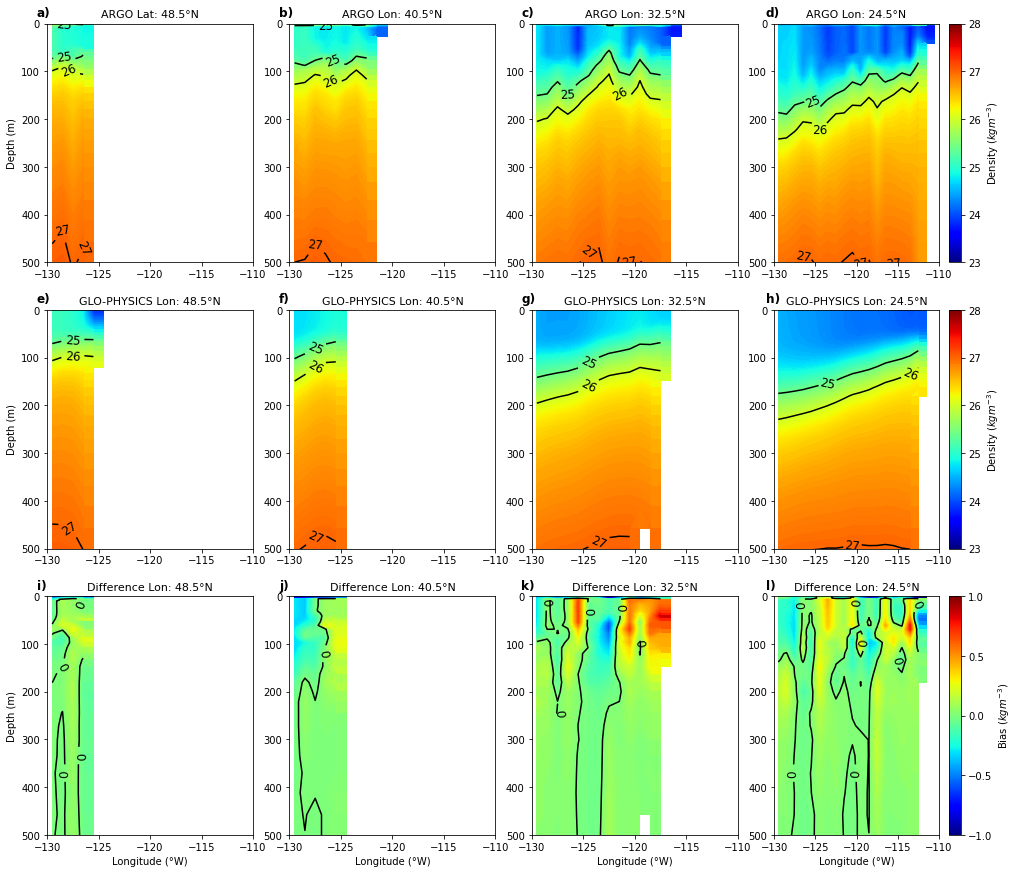

In [55]:
import string
vmins= [23]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [28]*8 + [1]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

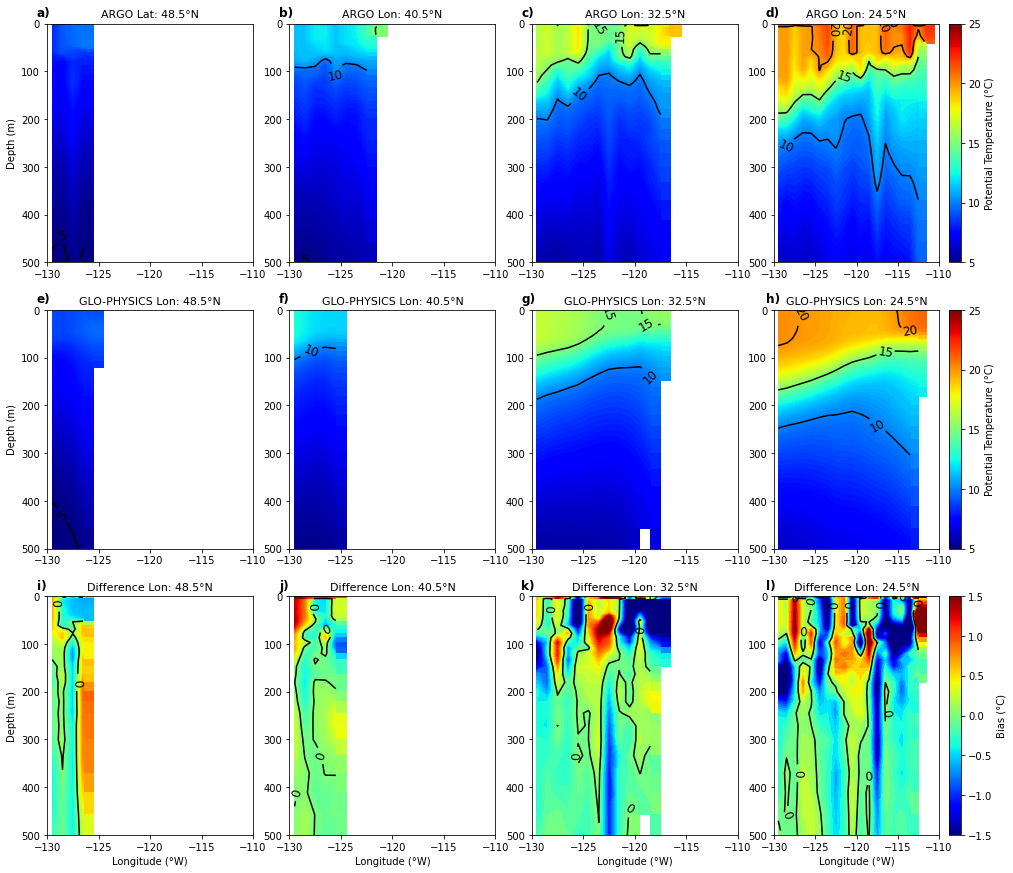

In [56]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

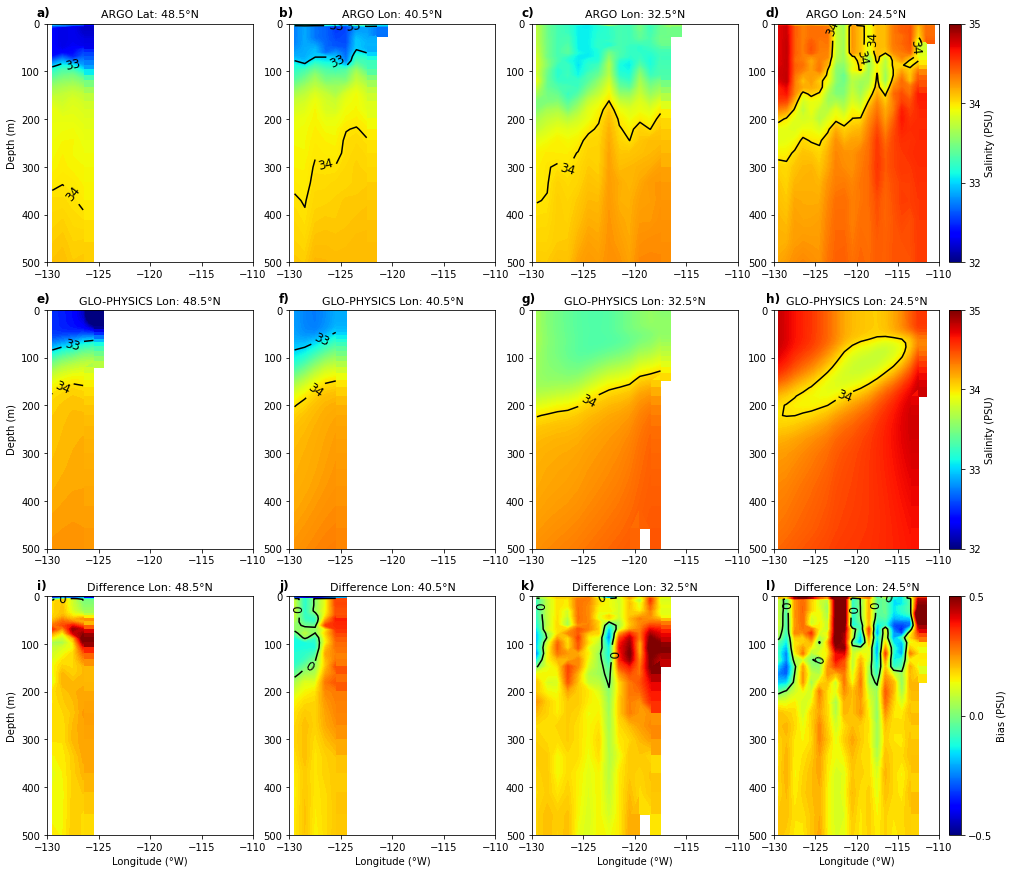

In [57]:
import string
vmins= [32]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [35]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[33,34,35,36]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Diagramas de Taylor

In [58]:
STD_D=[];CORRCOEF_D=[];RMSE_D=[]
STD_S=[];CORRCOEF_S=[];RMSE_S=[]
STD_T=[];CORRCOEF_T=[];RMSE_T=[]
for i in range(40):
  ###### DEN ######
  modelo= np.flipud(M_final.D.values[i,:,:]).flatten()
  satelite= A_final.D.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_D.append(np.ma.std(P.ravel()))
  CORRCOEF_D.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_D.append(np.sqrt(np.mean((P-A)**2)))
  ###### SAL ######
  modelo= np.flipud(M_final.S.values[i,:,:]).flatten()
  satelite= A_final.S.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_S.append(np.ma.std(P.ravel()))
  CORRCOEF_S.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_S.append(np.sqrt(np.mean((P-A)**2)))
  ###### TEMP ######
  modelo= np.flipud(M_final.T.values[i,:,:]).flatten()
  satelite= A_final.T.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_T.append(np.ma.std(P.ravel()))
  CORRCOEF_T.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_T.append(np.sqrt(np.mean((P-A)**2)))

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

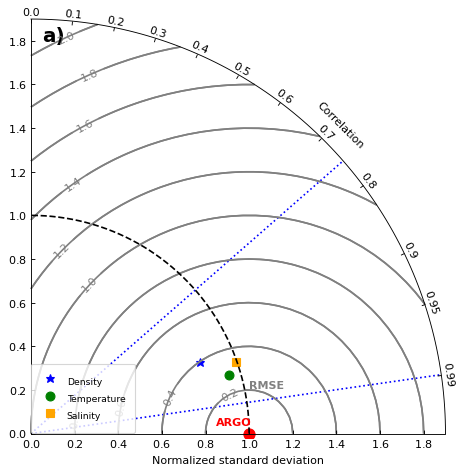

In [59]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0., 1.9), label='ARGO')
pp=[]
ttt=TayDia.add_sample(np.mean(STD_D), np.mean(CORRCOEF_D)+0.1, marker="*", linestyle='None', color='blue', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_T), np.mean(CORRCOEF_T), marker="o", linestyle='None', color='green', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_S), np.mean(CORRCOEF_S), marker="s", linestyle='None', color='orange', ms=8);pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -1.25**2)],[0,1.25], color='blue',linestyle=':') # correlacion 0.75
plt.plot([0,NP.sqrt(1.9**2 -0.27**2)],[0,0.27], color='blue',linestyle=':') # correlacion 0.99
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, ['Density','Temperature','Salinity'],  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'ARGO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'a)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

## Validacion -MAM

In [60]:
MAM= interpolador_capas(dataframe= lista_dfs[1], max_depth= 600, intervalo=1)
MAM

Tamaño de los dataframes generados : 6060
(3642060, 6)


Lon     Lat  Presion_interp   D_interp  T_interp   S_interp
0       -129.9979  49.367               0  25.729427  7.793351  32.919785
1       -129.9979  49.367               1  25.224037  7.847141  32.297791
2       -129.9979  49.367               2  25.222268  7.850974  32.296204
3       -129.9979  49.367               3  25.220853  7.854032  32.294932
4       -129.9979  49.367               4  25.219914  7.856309  32.294143
...           ...     ...             ...        ...       ...        ...
3642055 -110.0050  21.178             596  27.102110  7.221297  34.556845
3642056 -110.0050  21.178             597  27.102257  7.219923  34.556690
3642057 -110.0050  21.178             598  27.102720  7.218013  34.557153
3642058 -110.0050  21.178             599  27.104012  7.213844  34.558022
3642059 -110.0050  21.178             600        NaN       NaN        NaN

[3642060 rows x 6 columns]

In [61]:
import scipy
from scipy.interpolate import griddata
ds_final= MAM #pasar los resultados del dataframe anteriores
# Lista para ir guardando cada matrix latxlon
datos_jan_D = []
datos_jan_T = []
datos_jan_S = []
for i in ds_final.Presion_interp.unique()[:-1]: # voy de 5m en adelante
  capa_x=ds_final[ds_final['Presion_interp']==i]
  # Grilla generica
  gridx = np.arange(-130+0.5,-110+0.5,1)# np.arange(-85,-70+1,1)
  gridy = np.arange(20+0.5, 50+0.5,1)#np.arange(-45, -15+1,1)
  grid_x, grid_y =scipy.meshgrid(gridx,gridy)
  points =np.array(capa_x[['Lon','Lat']])
  values_D=np.array(capa_x['D_interp'])
  values_T=np.array(capa_x['T_interp'])
  values_S=np.array(capa_x['S_interp'])
  # Interpoladores
  grid_z0_D=griddata(points,values_D, (grid_x,grid_y),method='linear')
  grid_z0_T=griddata(points,values_T, (grid_x,grid_y),method='linear')
  grid_z0_S=griddata(points,values_S, (grid_x,grid_y),method='linear')
  # Rotacion en el eje y Sur-Norte
  grid_z0_1_D=np.flip(grid_z0_D, axis=0)
  grid_z0_1_T=np.flip(grid_z0_T, axis=0)
  grid_z0_1_S=np.flip(grid_z0_S, axis=0)
  #print(grid_z0_1.shape)# Esto no es necesario despues
  datos_jan_D.append(grid_z0_1_D);datos_jan_T.append(grid_z0_1_T);datos_jan_S.append(grid_z0_1_S)
datos_D = np.stack(datos_jan_D);datos_T = np.stack(datos_jan_T);datos_S = np.stack(datos_jan_S)

In [62]:
print(datos_D.shape,datos_T.shape,datos_S.shape)

(600, 30, 20) (600, 30, 20) (600, 30, 20)


In [63]:
# Modelo data
T_DJF=np.mean(reanal.where(((reanal.month==3)|(reanal.month==4)|(reanal.month==5)), drop=True).CT.values,axis=0)
S_DJF=np.mean(reanal.where(((reanal.month==3)|(reanal.month==4)|(reanal.month==5)), drop=True).SA.values,axis=0)
D_DJF=np.mean(reanal.where(((reanal.month==3)|(reanal.month==4)|(reanal.month==5)), drop=True).D.values,axis=0)
print(T_DJF.shape, S_DJF.shape, D_DJF.shape)

(40, 121, 81) (40, 121, 81) (40, 121, 81)


In [64]:
# Interpolar a todas las capas para la misma grilla
x1= np.arange(-130+0.5, -110+0.5,1)
y1= list(np.arange(20+0.5, 50+0.5,1));y1=y1[::-1];y1= np.array(y1)
X_t, Y_t= np.meshgrid(x1,y1)
dat_D = []
dat_T = []
dat_S = []
for i in range(T_DJF.shape[0]):
  T_X=basemap.interp(datain=np.flipud(T_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  D_X=basemap.interp(datain=np.flipud(D_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  S_X=basemap.interp(datain=np.flipud(S_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  dat_D.append(D_X);dat_T.append(T_X);dat_S.append(S_X)
M_D = np.stack(dat_D);M_T = np.stack(dat_T);M_S = np.stack(dat_S)
print(M_D.shape, M_T.shape, M_S.shape)

(40, 30, 20) (40, 30, 20) (40, 30, 20)


<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -129.5 -128.5 -127.5 -126.5 ... -112.5 -111.5 -110.5
  * lat      (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 21.61 21.56 21.49 21.47 ... nan nan nan
    S        (depth, lat, lon) float64 34.85 34.83 34.8 34.77 ... nan nan nan
    D        (depth, lat, lon) float64 24.13 24.13 24.13 24.12 ... nan nan nan

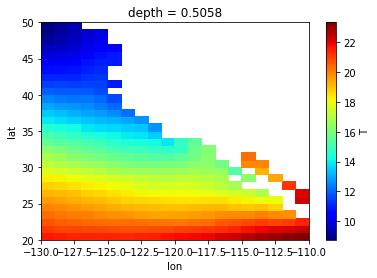

In [65]:
M_final=dt=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],M_T),"S":(['depth',"lat","lon"],M_S),"D":(['depth',"lat","lon"],M_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.arange(20+0.5, 50+0.5,1), 
                        "depth": reanal.depth.values})
M_final.T.sel(depth=M_final.depth.values[0]).plot(cmap='jet')
M_final

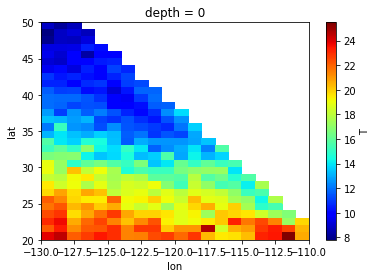

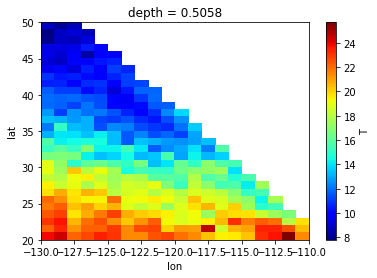

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -129.5 -128.5 -127.5 -126.5 ... -112.5 -111.5 -110.5
  * lat      (lat) float64 49.5 48.5 47.5 46.5 45.5 ... 24.5 23.5 22.5 21.5 20.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 8.892 8.237 8.729 ... 7.666 7.642 7.677
    S        (depth, lat, lon) float64 32.86 32.99 32.71 ... 34.54 34.52 34.52
    D        (depth, lat, lon) float64 25.51 25.72 25.43 ... 27.02 27.01 27.0

In [66]:
A_no_interp=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.array(list(np.arange(20+0.5, 50+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)})
A_final=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.array(list(np.arange(20+0.5, 50+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)}).interp(depth=reanal.depth.values)
A_no_interp.T.sel(depth=A_no_interp.depth.values[0]).plot(cmap='jet')
plt.show()
A_final.T.sel(depth=A_final.depth.values[0]).plot(cmap='jet')
plt.show()
A_final

### Graficas finales transectas

### Latitudinales

In [67]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lon_Y= [-128.5,-122.5,-116.5,-112.5]
for i in range(4):
  tran_lat_d=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_s=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_t=A_final.sel(lon=lon_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lon=lon_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lon=lon_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lon=lon_Y[i]).T.values
  tran_lat_dx=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_sx=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_tx=A_final.sel(lon=lon_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(np.flip(tran_lat_M_d,axis=1));lista_ARGOX_LAT_D.append(np.flip((M_final.sel(lon=lon_Y[i]).D-A_final.sel(lon=lon_Y[i]).D).values,axis=1))
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(np.flip(tran_lat_M_s,axis=1));lista_ARGOX_LAT_S.append(np.flip((M_final.sel(lon=lon_Y[i]).S-A_final.sel(lon=lon_Y[i]).S).values,axis=1))
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(np.flip(tran_lat_M_t,axis=1));lista_ARGOX_LAT_T.append(np.flip((M_final.sel(lon=lon_Y[i]).T-A_final.sel(lon=lon_Y[i]).T).values,axis=1))
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

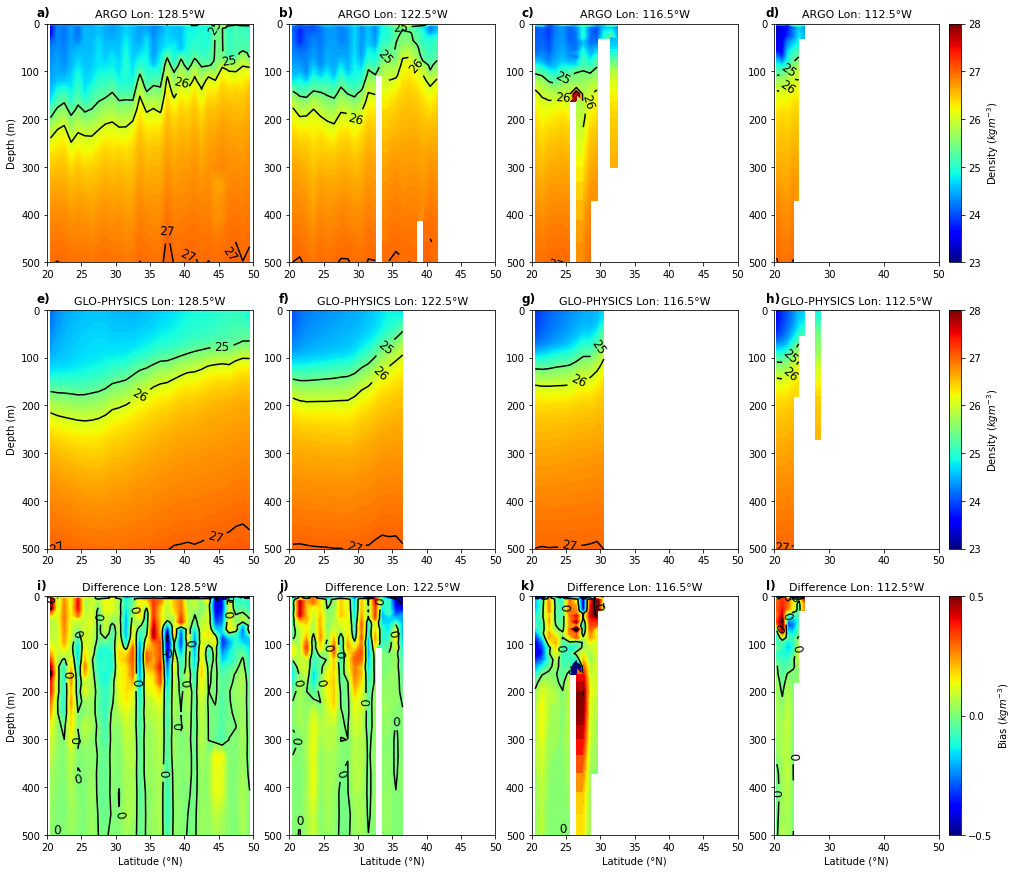

In [68]:
import string
vmins= [23]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [28]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[-0.5,0,0.5]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

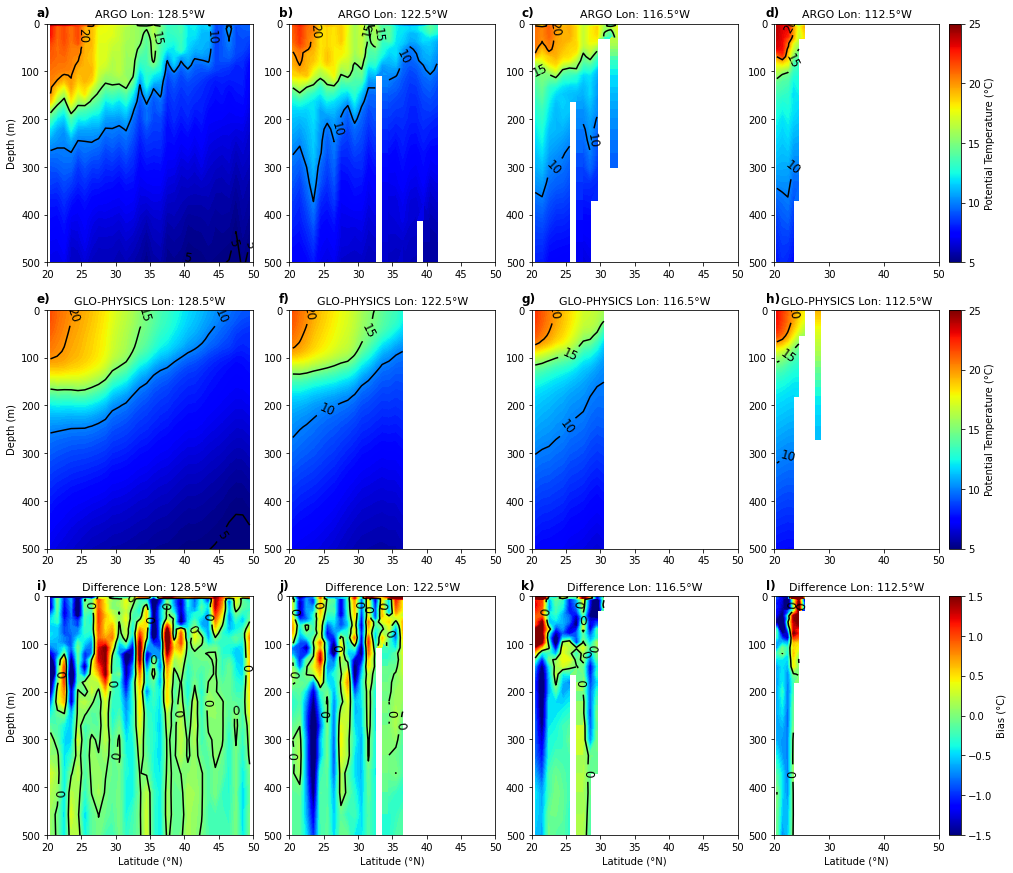

In [69]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

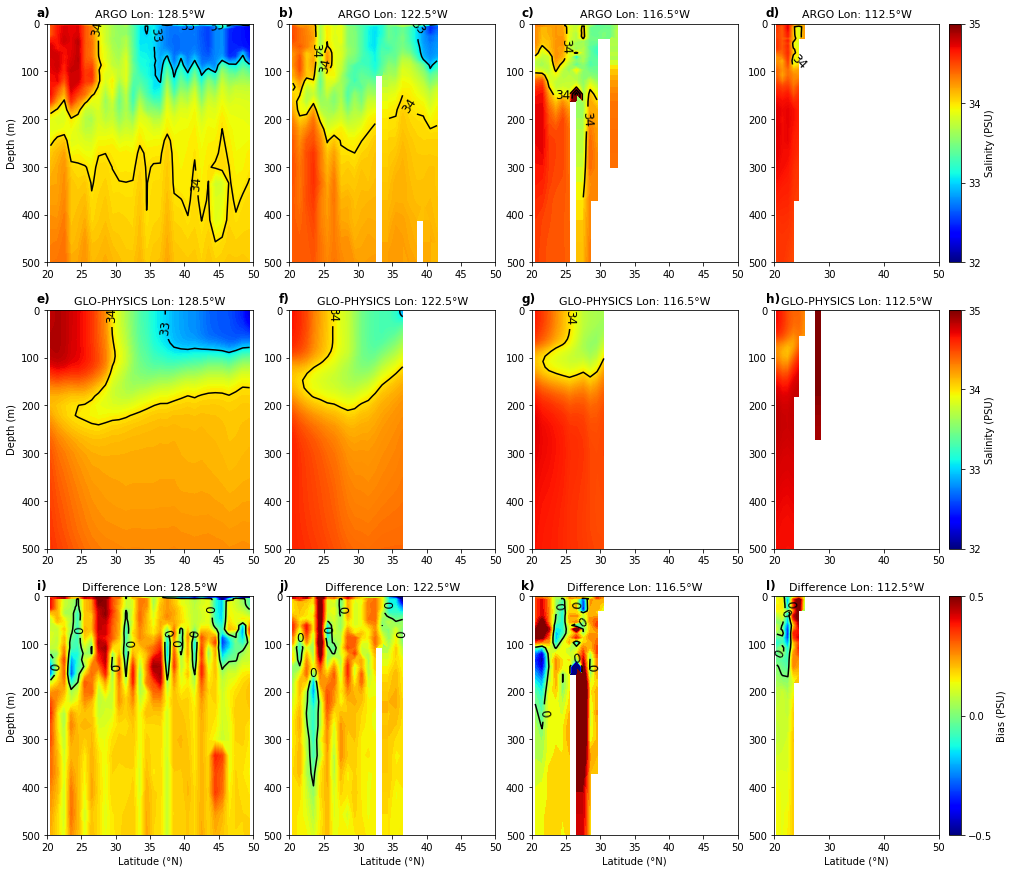

In [70]:
import string
vmins= [32]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [35]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[33,34,35,36]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Longitudinales

In [71]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lat_Y= [48.5,40.5,32.5,24.5]
for i in range(4):
  tran_lat_d=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_s=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_t=A_final.sel(lat=lat_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lat=lat_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lat=lat_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lat=lat_Y[i]).T.values
  tran_lat_dx=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_sx=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_tx=A_final.sel(lat=lat_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(tran_lat_M_d);lista_ARGOX_LAT_D.append((M_final.sel(lat=lat_Y[i]).D-A_final.sel(lat=lat_Y[i]).D).values)
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(tran_lat_M_s);lista_ARGOX_LAT_S.append((M_final.sel(lat=lat_Y[i]).S-A_final.sel(lat=lat_Y[i]).S).values)
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(tran_lat_M_t);lista_ARGOX_LAT_T.append((M_final.sel(lat=lat_Y[i]).T-A_final.sel(lat=lat_Y[i]).T).values)
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_D[0][lista_final_D[0]>27.10728928778205]= 27.10728928778205-0.2
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_S[0][lista_final_S[0]>36]= 36-0.4
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

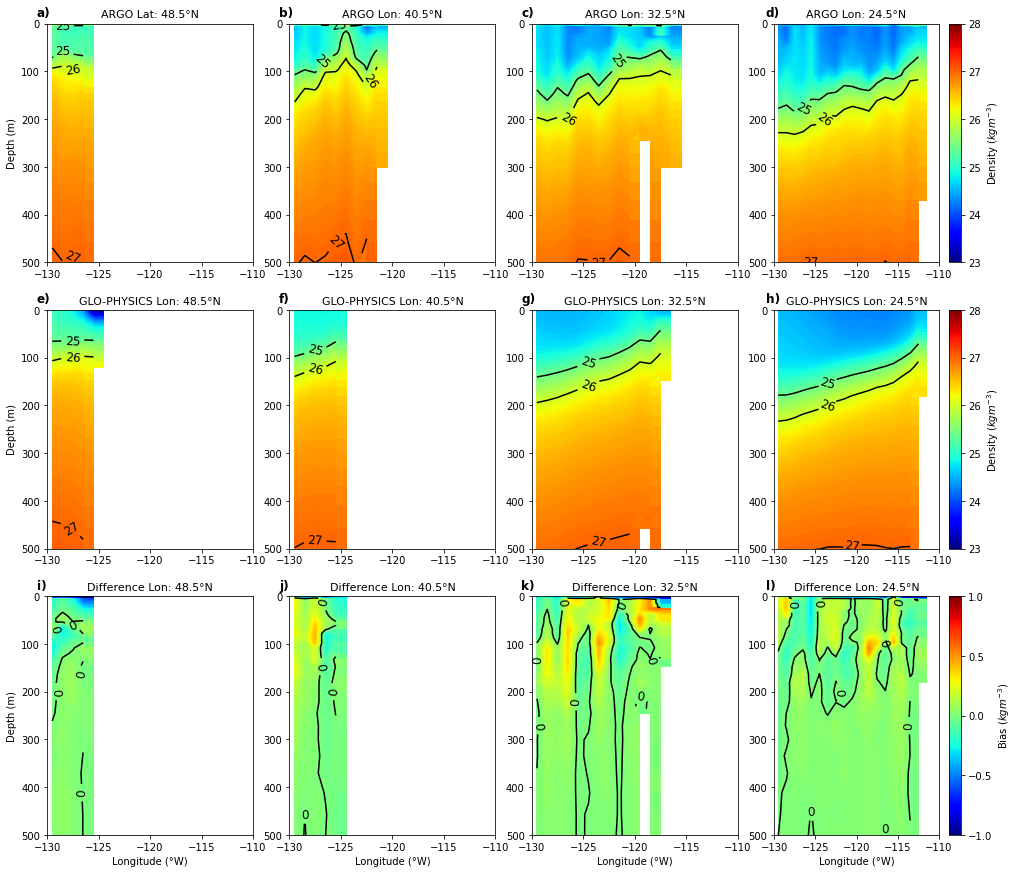

In [72]:
import string
vmins= [23]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [28]*8 + [1]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

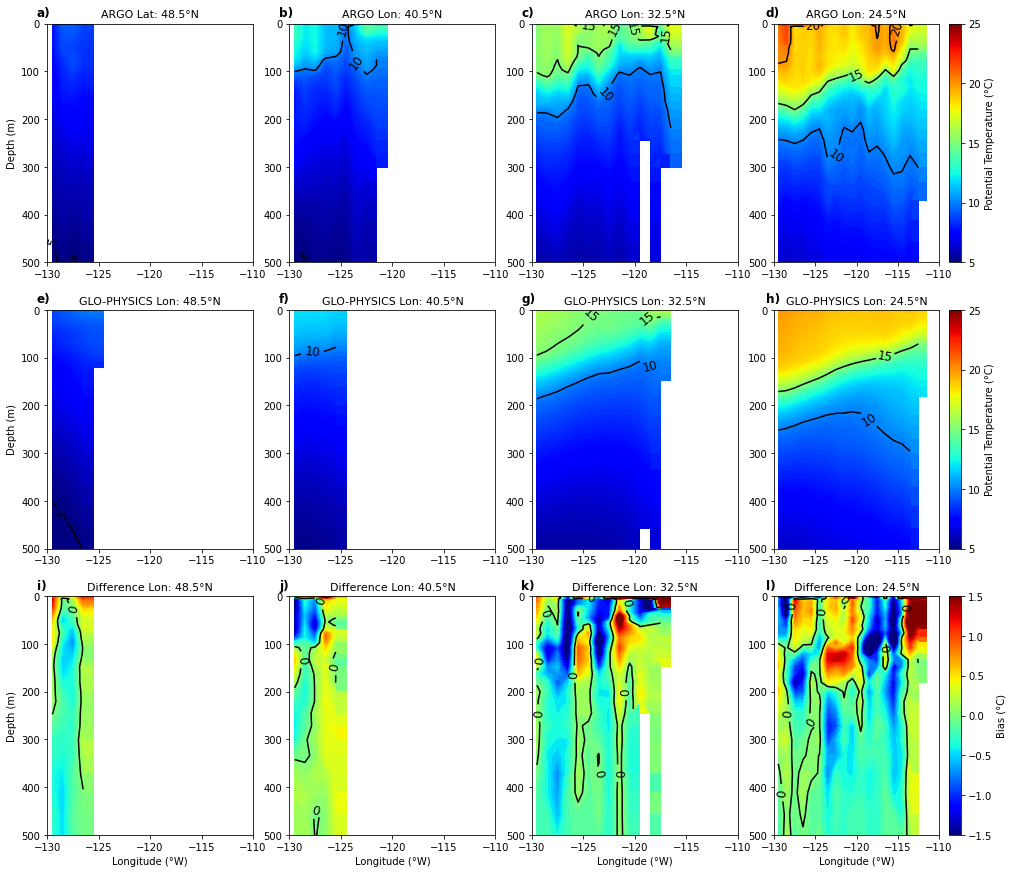

In [73]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

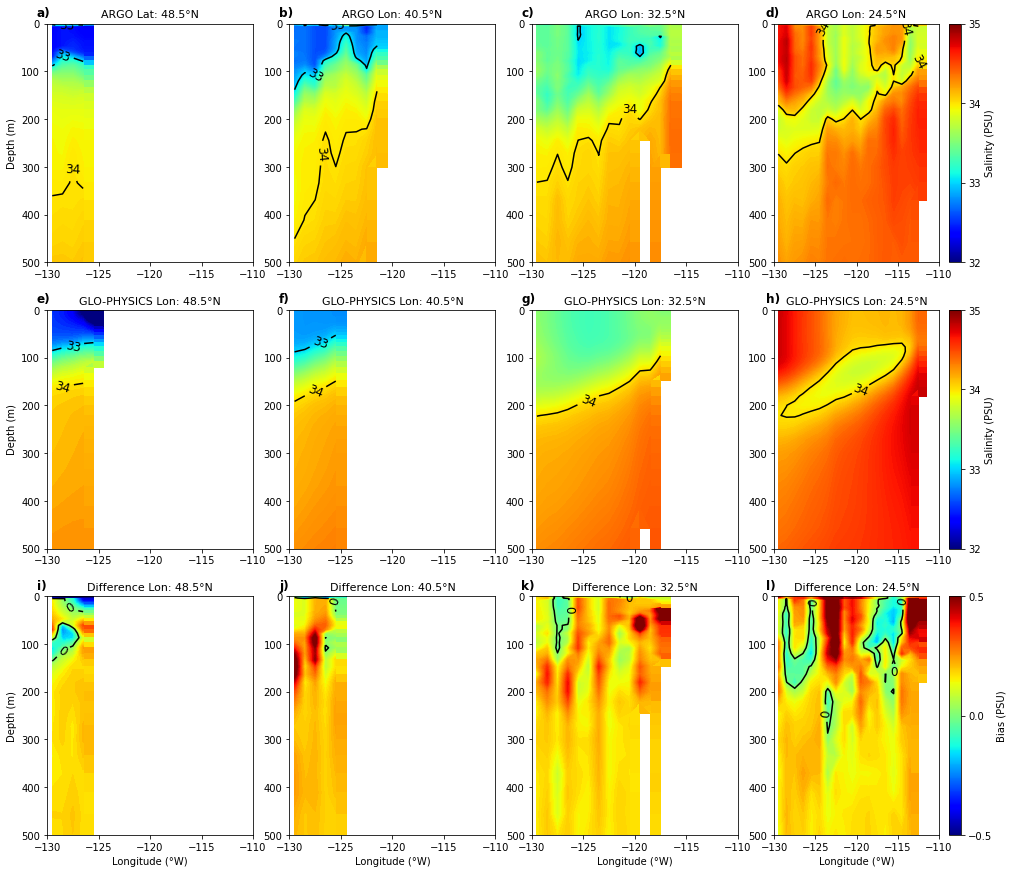

In [74]:
import string
vmins= [32]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [35]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[33,34,35,36]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Diagramas de Taylor

In [75]:
STD_D=[];CORRCOEF_D=[];RMSE_D=[]
STD_S=[];CORRCOEF_S=[];RMSE_S=[]
STD_T=[];CORRCOEF_T=[];RMSE_T=[]
for i in range(40):
  ###### DEN ######
  modelo= np.flipud(M_final.D.values[i,:,:]).flatten()
  satelite= A_final.D.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_D.append(np.ma.std(P.ravel()))
  CORRCOEF_D.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_D.append(np.sqrt(np.mean((P-A)**2)))
  ###### SAL ######
  modelo= np.flipud(M_final.S.values[i,:,:]).flatten()
  satelite= A_final.S.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_S.append(np.ma.std(P.ravel()))
  CORRCOEF_S.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_S.append(np.sqrt(np.mean((P-A)**2)))
  ###### TEMP ######
  modelo= np.flipud(M_final.T.values[i,:,:]).flatten()
  satelite= A_final.T.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_T.append(np.ma.std(P.ravel()))
  CORRCOEF_T.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_T.append(np.sqrt(np.mean((P-A)**2)))

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

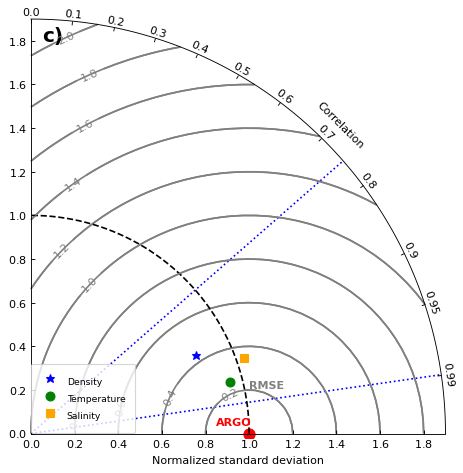

In [76]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0., 1.9), label='ARGO')
pp=[]
ttt=TayDia.add_sample(np.mean(STD_D), np.mean(CORRCOEF_D)+0.05, marker="*", linestyle='None', color='blue', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_T), np.mean(CORRCOEF_T), marker="o", linestyle='None', color='green', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_S), np.mean(CORRCOEF_S), marker="s", linestyle='None', color='orange', ms=8);pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -1.25**2)],[0,1.25], color='blue',linestyle=':') # correlacion 0.75
plt.plot([0,NP.sqrt(1.9**2 -0.27**2)],[0,0.27], color='blue',linestyle=':') # correlacion 0.99
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, ['Density','Temperature','Salinity'],  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'ARGO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'c)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

## Validacion - JJA

In [77]:
JJA= interpolador_capas(dataframe= lista_dfs[2], max_depth= 600, intervalo=1)
JJA

Tamaño de los dataframes generados : 5890
(3539890, 6)


Lon     Lat  Presion_interp   D_interp   T_interp   S_interp
0       -130.000  22.234               0  24.513903  21.190133  34.461565
1       -130.000  22.234               1  24.519105  21.153222  34.460817
2       -130.000  22.234               2  24.524306  21.116311  34.460070
3       -130.000  22.234               3  24.529508  21.079399  34.459323
4       -130.000  22.234               4  24.534710  21.042488  34.458576
...          ...     ...             ...        ...        ...        ...
3539885 -110.021  21.802             596  27.191629   6.376211  34.525826
3539886 -110.021  21.802             597  27.192375   6.360935  34.524254
3539887 -110.021  21.802             598  27.193042   6.347026  34.522786
3539888 -110.021  21.802             599  27.193336   6.338454  34.521714
3539889 -110.021  21.802             600        NaN        NaN        NaN

[3539890 rows x 6 columns]

In [78]:
import scipy
from scipy.interpolate import griddata
ds_final= JJA #pasar los resultados del dataframe anteriores
# Lista para ir guardando cada matrix latxlon
datos_jan_D = []
datos_jan_T = []
datos_jan_S = []
for i in ds_final.Presion_interp.unique()[:-1]: # voy de 5m en adelante
  capa_x=ds_final[ds_final['Presion_interp']==i]
  # Grilla generica
  gridx = np.arange(-130+0.5,-110+0.5,1)# np.arange(-85,-70+1,1)
  gridy = np.arange(20+0.5, 50+0.5,1)#np.arange(-45, -15+1,1)
  grid_x, grid_y =scipy.meshgrid(gridx,gridy)
  points =np.array(capa_x[['Lon','Lat']])
  values_D=np.array(capa_x['D_interp'])
  values_T=np.array(capa_x['T_interp'])
  values_S=np.array(capa_x['S_interp'])
  # Interpoladores
  grid_z0_D=griddata(points,values_D, (grid_x,grid_y),method='linear')
  grid_z0_T=griddata(points,values_T, (grid_x,grid_y),method='linear')
  grid_z0_S=griddata(points,values_S, (grid_x,grid_y),method='linear')
  # Rotacion en el eje y Sur-Norte
  grid_z0_1_D=np.flip(grid_z0_D, axis=0)
  grid_z0_1_T=np.flip(grid_z0_T, axis=0)
  grid_z0_1_S=np.flip(grid_z0_S, axis=0)
  #print(grid_z0_1.shape)# Esto no es necesario despues
  datos_jan_D.append(grid_z0_1_D);datos_jan_T.append(grid_z0_1_T);datos_jan_S.append(grid_z0_1_S)
datos_D = np.stack(datos_jan_D);datos_T = np.stack(datos_jan_T);datos_S = np.stack(datos_jan_S)

In [79]:
print(datos_D.shape,datos_T.shape,datos_S.shape)

(600, 30, 20) (600, 30, 20) (600, 30, 20)


In [80]:
# Modelo data
T_DJF=np.mean(reanal.where(((reanal.month==6)|(reanal.month==7)|(reanal.month==8)), drop=True).CT.values,axis=0)
S_DJF=np.mean(reanal.where(((reanal.month==6)|(reanal.month==7)|(reanal.month==8)), drop=True).SA.values,axis=0)
D_DJF=np.mean(reanal.where(((reanal.month==6)|(reanal.month==7)|(reanal.month==8)), drop=True).D.values,axis=0)
print(T_DJF.shape, S_DJF.shape, D_DJF.shape)

(40, 121, 81) (40, 121, 81) (40, 121, 81)


In [81]:
# Interpolar a todas las capas para la misma grilla
x1= np.arange(-130+0.5, -110+0.5,1)
y1= list(np.arange(20+0.5, 50+0.5,1));y1=y1[::-1];y1= np.array(y1)
X_t, Y_t= np.meshgrid(x1,y1)
dat_D = []
dat_T = []
dat_S = []
for i in range(T_DJF.shape[0]):
  T_X=basemap.interp(datain=np.flipud(T_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  D_X=basemap.interp(datain=np.flipud(D_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  S_X=basemap.interp(datain=np.flipud(S_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  dat_D.append(D_X);dat_T.append(T_X);dat_S.append(S_X)
M_D = np.stack(dat_D);M_T = np.stack(dat_T);M_S = np.stack(dat_S)
print(M_D.shape, M_T.shape, M_S.shape)

(40, 30, 20) (40, 30, 20) (40, 30, 20)


<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -129.5 -128.5 -127.5 -126.5 ... -112.5 -111.5 -110.5
  * lat      (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 23.35 23.28 23.27 23.37 ... nan nan nan
    S        (depth, lat, lon) float64 34.83 34.81 34.79 34.77 ... nan nan nan
    D        (depth, lat, lon) float64 23.62 23.63 23.61 23.57 ... nan nan nan

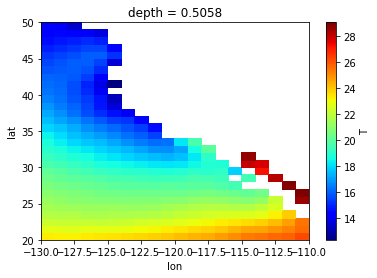

In [82]:
M_final=dt=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],M_T),"S":(['depth',"lat","lon"],M_S),"D":(['depth',"lat","lon"],M_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.arange(20+0.5, 50+0.5,1), 
                        "depth": reanal.depth.values})
M_final.T.sel(depth=M_final.depth.values[0]).plot(cmap='jet')
M_final

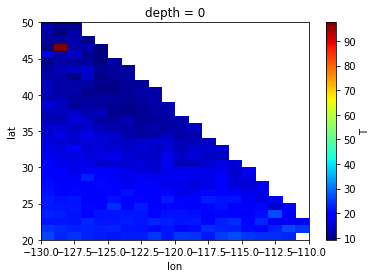

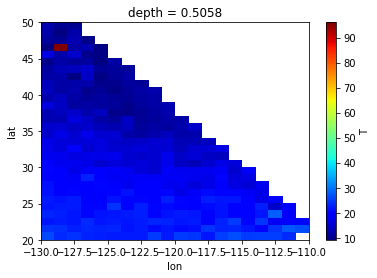

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -129.5 -128.5 -127.5 -126.5 ... -112.5 -111.5 -110.5
  * lat      (lat) float64 49.5 48.5 47.5 46.5 45.5 ... 24.5 23.5 22.5 21.5 20.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 12.83 10.75 10.65 nan ... 7.543 7.661 nan
    S        (depth, lat, lon) float64 32.53 32.81 32.87 nan ... 34.52 34.52 nan
    D        (depth, lat, lon) float64 25.11 25.26 25.46 nan ... 27.03 27.01 nan

In [83]:
A_no_interp=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.array(list(np.arange(20+0.5, 50+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)})
A_final=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.array(list(np.arange(20+0.5, 50+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)}).interp(depth=reanal.depth.values)
A_no_interp.T.sel(depth=A_no_interp.depth.values[0]).plot(cmap='jet')
plt.show()
A_final.T.sel(depth=A_final.depth.values[0]).plot(cmap='jet')
plt.show()
A_final

### Graficas finales transectas

### Latitudinales

In [84]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lon_Y= [-128.5,-122.5,-116.5,-112.5]
for i in range(4):
  tran_lat_d=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_s=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_t=A_final.sel(lon=lon_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lon=lon_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lon=lon_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lon=lon_Y[i]).T.values
  tran_lat_dx=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_sx=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_tx=A_final.sel(lon=lon_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(np.flip(tran_lat_M_d,axis=1));lista_ARGOX_LAT_D.append(np.flip((M_final.sel(lon=lon_Y[i]).D-A_final.sel(lon=lon_Y[i]).D).values,axis=1))
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(np.flip(tran_lat_M_s,axis=1));lista_ARGOX_LAT_S.append(np.flip((M_final.sel(lon=lon_Y[i]).S-A_final.sel(lon=lon_Y[i]).S).values,axis=1))
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(np.flip(tran_lat_M_t,axis=1));lista_ARGOX_LAT_T.append(np.flip((M_final.sel(lon=lon_Y[i]).T-A_final.sel(lon=lon_Y[i]).T).values,axis=1))
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

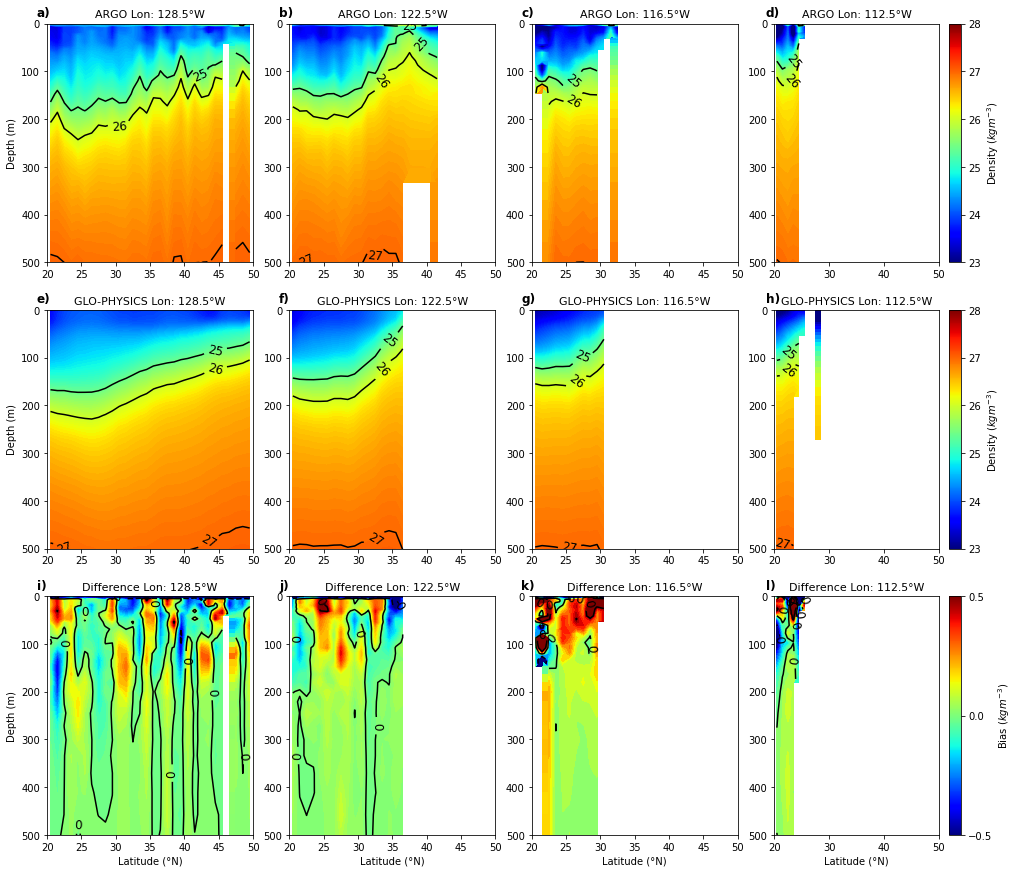

In [85]:
import string
vmins= [23]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [28]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[-0.5,0,0.5]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

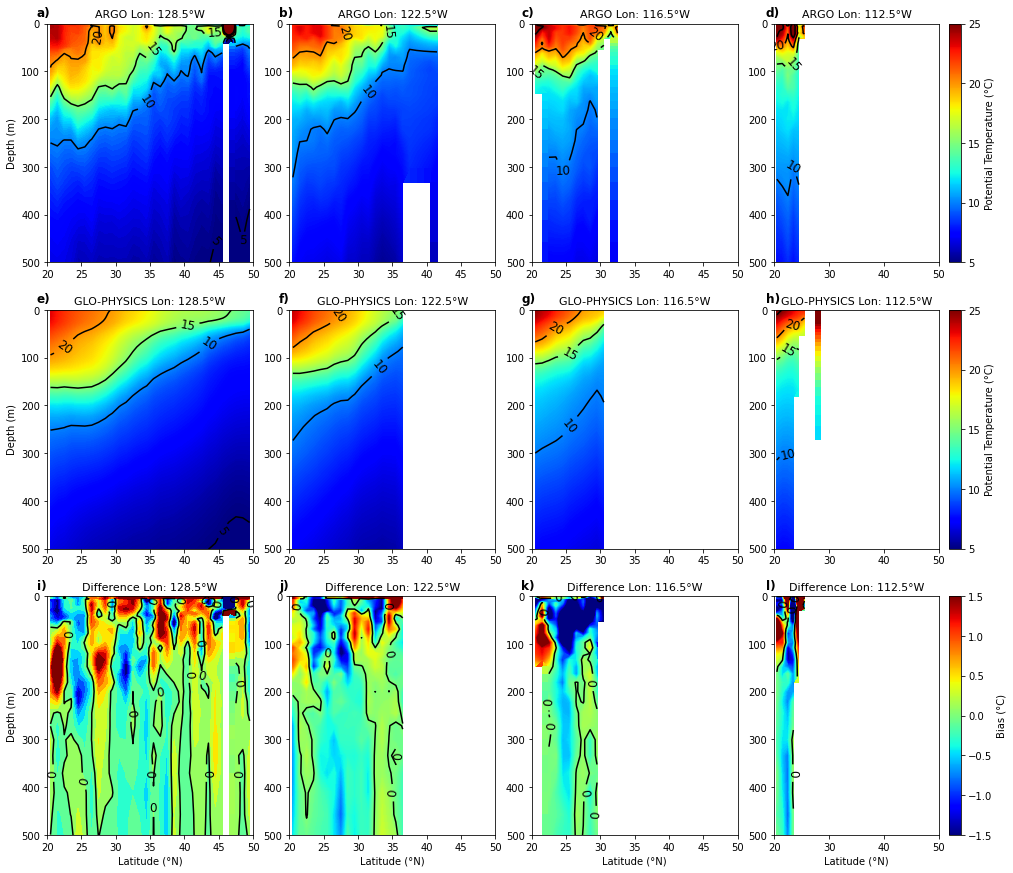

In [87]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=500)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

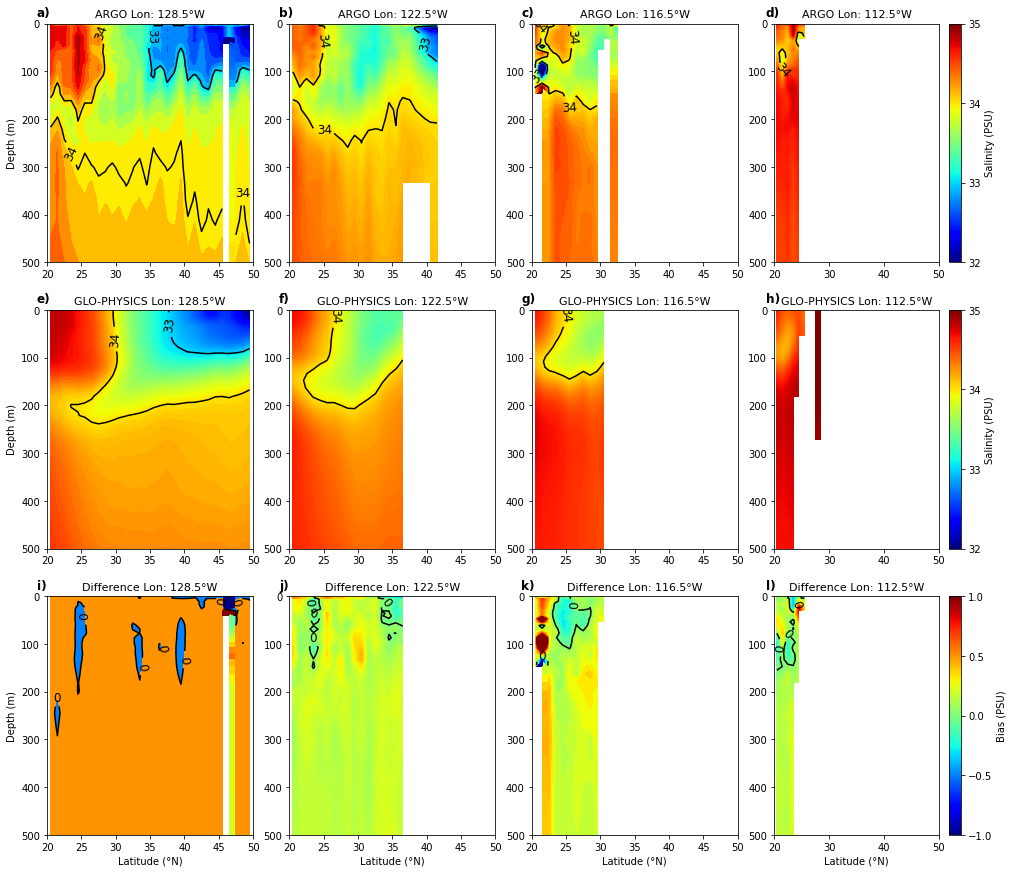

In [90]:
import string
vmins= [32]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [35]*8 + [1]*4 #limites superiores replicados
levelsx=[[33,34,35,36]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
lista_final_S[0][lista_final_S[0]>35]= 33
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Longitudinales

In [91]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lat_Y= [48.5,40.5,32.5,24.5]
for i in range(4):
  tran_lat_d=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_s=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_t=A_final.sel(lat=lat_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lat=lat_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lat=lat_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lat=lat_Y[i]).T.values
  tran_lat_dx=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_sx=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_tx=A_final.sel(lat=lat_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(tran_lat_M_d);lista_ARGOX_LAT_D.append((M_final.sel(lat=lat_Y[i]).D-A_final.sel(lat=lat_Y[i]).D).values)
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(tran_lat_M_s);lista_ARGOX_LAT_S.append((M_final.sel(lat=lat_Y[i]).S-A_final.sel(lat=lat_Y[i]).S).values)
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(tran_lat_M_t);lista_ARGOX_LAT_T.append((M_final.sel(lat=lat_Y[i]).T-A_final.sel(lat=lat_Y[i]).T).values)
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_D[0][lista_final_D[0]>27.10728928778205]= 27.10728928778205-0.2
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_S[0][lista_final_S[0]>36]= 36-0.4
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

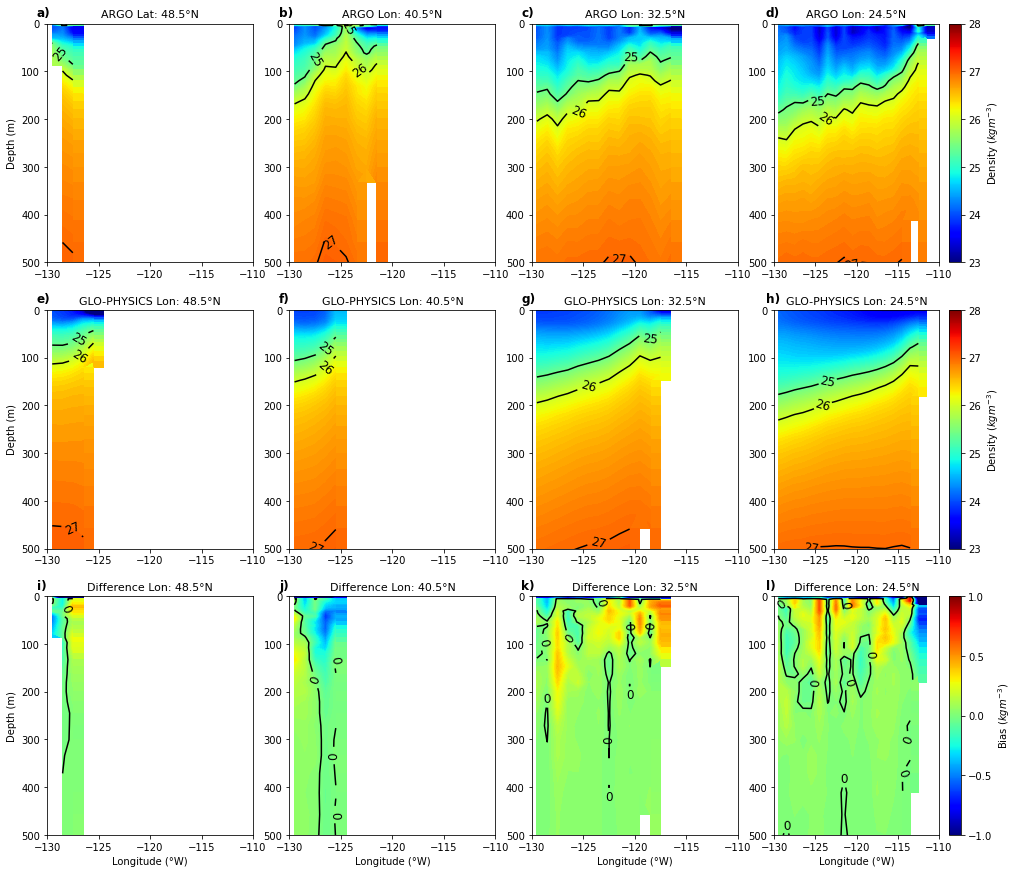

In [92]:
import string
vmins= [23]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [28]*8 + [1]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

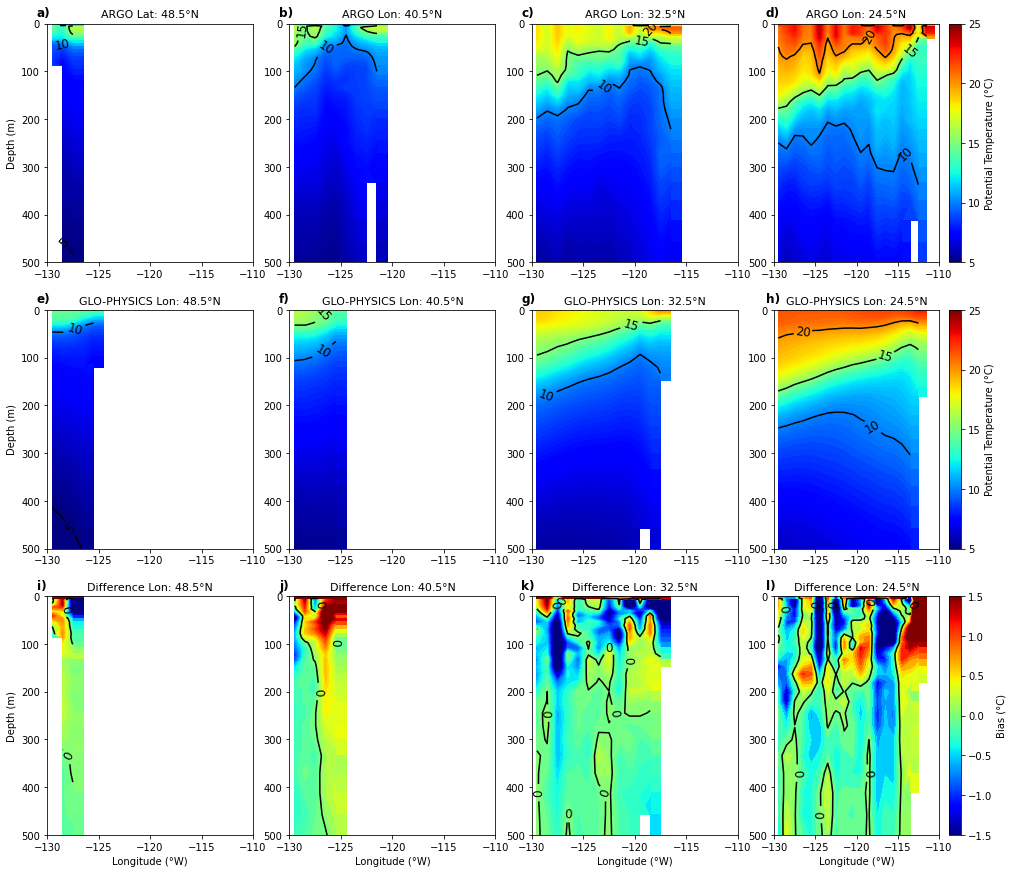

In [93]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

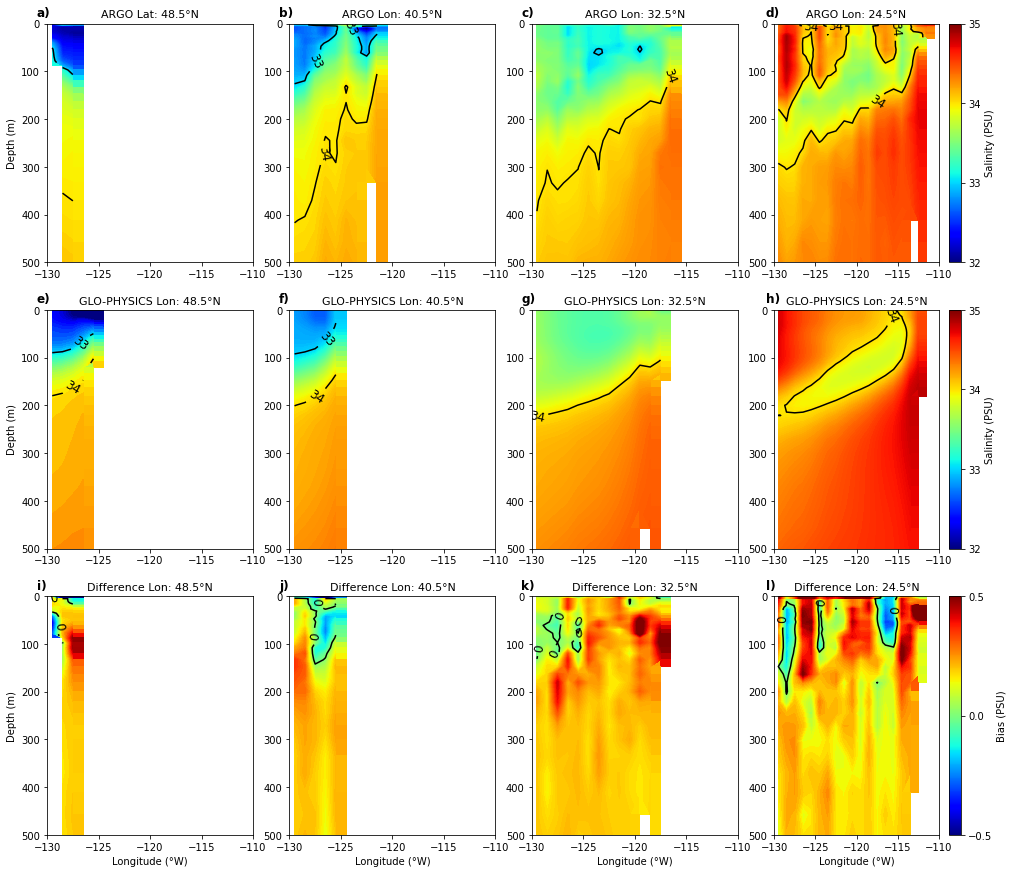

In [94]:
import string
vmins= [32]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [35]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[33,34,35,36]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Diagramas de Taylor

In [95]:
STD_D=[];CORRCOEF_D=[];RMSE_D=[]
STD_S=[];CORRCOEF_S=[];RMSE_S=[]
STD_T=[];CORRCOEF_T=[];RMSE_T=[]
for i in range(40):
  ###### DEN ######
  modelo= np.flipud(M_final.D.values[i,:,:]).flatten()
  satelite= A_final.D.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_D.append(np.ma.std(P.ravel()))
  CORRCOEF_D.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_D.append(np.sqrt(np.mean((P-A)**2)))
  ###### SAL ######
  modelo= np.flipud(M_final.S.values[i,:,:]).flatten()
  satelite= A_final.S.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_S.append(np.ma.std(P.ravel()))
  CORRCOEF_S.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_S.append(np.sqrt(np.mean((P-A)**2)))
  ###### TEMP ######
  modelo= np.flipud(M_final.T.values[i,:,:]).flatten()
  satelite= A_final.T.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_T.append(np.ma.std(P.ravel()))
  CORRCOEF_T.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_T.append(np.sqrt(np.mean((P-A)**2)))

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

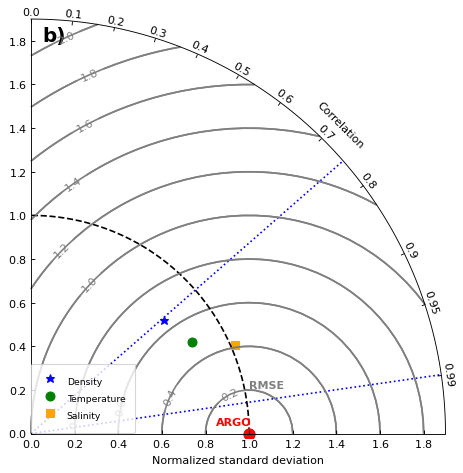

In [96]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0., 1.9), label='ARGO')
pp=[]
ttt=TayDia.add_sample(np.mean(STD_D), np.mean(CORRCOEF_D), marker="*", linestyle='None', color='blue', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_T), np.mean(CORRCOEF_T), marker="o", linestyle='None', color='green', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_S), np.mean(CORRCOEF_S), marker="s", linestyle='None', color='orange', ms=8);pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -1.25**2)],[0,1.25], color='blue',linestyle=':') # correlacion 0.75
plt.plot([0,NP.sqrt(1.9**2 -0.27**2)],[0,0.27], color='blue',linestyle=':') # correlacion 0.99
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, ['Density','Temperature','Salinity'],  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'ARGO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'b)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

## Validacion-SON

In [97]:
SON= interpolador_capas(dataframe= lista_dfs[3], max_depth= 600, intervalo=1)
SON

Tamaño de los dataframes generados : 6024
(3620424, 6)


Lon       Lat  Presion_interp   D_interp   T_interp   S_interp
0       -129.9955  30.59756               0        NaN        NaN        NaN
1       -129.9955  30.59756               1        NaN        NaN        NaN
2       -129.9955  30.59756               2  24.368030  15.083000  32.877800
3       -129.9955  30.59756               3        NaN        NaN        NaN
4       -129.9955  30.59756               4        NaN        NaN        NaN
...           ...       ...             ...        ...        ...        ...
3620419 -110.0940  20.69800             596  27.111467   6.855686  34.505075
3620420 -110.0940  20.69800             597  27.113102   6.848067  34.505793
3620421 -110.0940  20.69800             598  27.115464   6.834042  34.506405
3620422 -110.0940  20.69800             599  27.118418   6.811353  34.506225
3620423 -110.0940  20.69800             600        NaN        NaN        NaN

[3620424 rows x 6 columns]

In [98]:
import scipy
from scipy.interpolate import griddata
ds_final= SON #pasar los resultados del dataframe anteriores
# Lista para ir guardando cada matrix latxlon
datos_jan_D = []
datos_jan_T = []
datos_jan_S = []
for i in ds_final.Presion_interp.unique()[:-1]: # voy de 5m en adelante
  capa_x=ds_final[ds_final['Presion_interp']==i]
  # Grilla generica
  gridx = np.arange(-130+0.5,-110+0.5,1)# np.arange(-85,-70+1,1)
  gridy = np.arange(20+0.5, 50+0.5,1)#np.arange(-45, -15+1,1)
  grid_x, grid_y =scipy.meshgrid(gridx,gridy)
  points =np.array(capa_x[['Lon','Lat']])
  values_D=np.array(capa_x['D_interp'])
  values_T=np.array(capa_x['T_interp'])
  values_S=np.array(capa_x['S_interp'])
  # Interpoladores
  grid_z0_D=griddata(points,values_D, (grid_x,grid_y),method='linear')
  grid_z0_T=griddata(points,values_T, (grid_x,grid_y),method='linear')
  grid_z0_S=griddata(points,values_S, (grid_x,grid_y),method='linear')
  # Rotacion en el eje y Sur-Norte
  grid_z0_1_D=np.flip(grid_z0_D, axis=0)
  grid_z0_1_T=np.flip(grid_z0_T, axis=0)
  grid_z0_1_S=np.flip(grid_z0_S, axis=0)
  #print(grid_z0_1.shape)# Esto no es necesario despues
  datos_jan_D.append(grid_z0_1_D);datos_jan_T.append(grid_z0_1_T);datos_jan_S.append(grid_z0_1_S)
datos_D = np.stack(datos_jan_D);datos_T = np.stack(datos_jan_T);datos_S = np.stack(datos_jan_S)

In [99]:
print(datos_D.shape,datos_T.shape,datos_S.shape)

(600, 30, 20) (600, 30, 20) (600, 30, 20)


In [100]:
# Modelo data
T_DJF=np.mean(reanal.where(((reanal.month==9)|(reanal.month==10)|(reanal.month==11)), drop=True).CT.values,axis=0)
S_DJF=np.mean(reanal.where(((reanal.month==9)|(reanal.month==10)|(reanal.month==11)), drop=True).SA.values,axis=0)
D_DJF=np.mean(reanal.where(((reanal.month==9)|(reanal.month==10)|(reanal.month==11)), drop=True).D.values,axis=0)
print(T_DJF.shape, S_DJF.shape, D_DJF.shape)

(40, 121, 81) (40, 121, 81) (40, 121, 81)


In [101]:
# Interpolar a todas las capas para la misma grilla
x1= np.arange(-130+0.5, -110+0.5,1)
y1= list(np.arange(20+0.5, 50+0.5,1));y1=y1[::-1];y1= np.array(y1)
X_t, Y_t= np.meshgrid(x1,y1)
dat_D = []
dat_T = []
dat_S = []
for i in range(T_DJF.shape[0]):
  T_X=basemap.interp(datain=np.flipud(T_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  D_X=basemap.interp(datain=np.flipud(D_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  S_X=basemap.interp(datain=np.flipud(S_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  dat_D.append(D_X);dat_T.append(T_X);dat_S.append(S_X)
M_D = np.stack(dat_D);M_T = np.stack(dat_T);M_S = np.stack(dat_S)
print(M_D.shape, M_T.shape, M_S.shape)

(40, 30, 20) (40, 30, 20) (40, 30, 20)


<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -129.5 -128.5 -127.5 -126.5 ... -112.5 -111.5 -110.5
  * lat      (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 24.2 24.2 24.22 24.31 ... nan nan nan nan
    S        (depth, lat, lon) float64 34.88 34.88 34.85 34.84 ... nan nan nan
    D        (depth, lat, lon) float64 23.42 23.41 23.39 23.35 ... nan nan nan

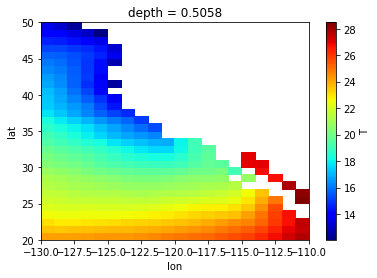

In [102]:
M_final=dt=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],M_T),"S":(['depth',"lat","lon"],M_S),"D":(['depth',"lat","lon"],M_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.arange(20+0.5, 50+0.5,1), 
                        "depth": reanal.depth.values})
M_final.T.sel(depth=M_final.depth.values[0]).plot(cmap='jet')
M_final

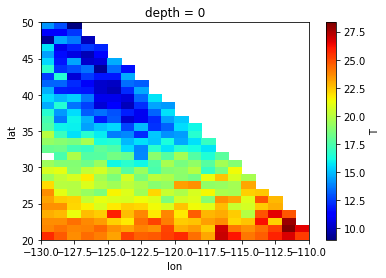

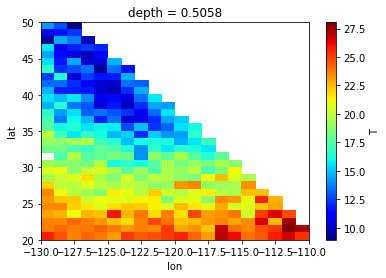

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -129.5 -128.5 -127.5 -126.5 ... -112.5 -111.5 -110.5
  * lat      (lat) float64 49.5 48.5 47.5 46.5 45.5 ... 24.5 23.5 22.5 21.5 20.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 14.21 12.85 8.935 ... 7.667 7.913 7.525
    S        (depth, lat, lon) float64 32.81 33.02 33.11 ... 34.52 34.52 34.53
    D        (depth, lat, lon) float64 25.06 25.42 25.77 ... 27.01 26.97 27.04

In [103]:
A_no_interp=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.array(list(np.arange(20+0.5, 50+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)})
A_final=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-130+0.5, -110+0.5,1), 
                        "lat": np.array(list(np.arange(20+0.5, 50+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)}).interp(depth=reanal.depth.values)
A_no_interp.T.sel(depth=A_no_interp.depth.values[0]).plot(cmap='jet')
plt.show()
A_final.T.sel(depth=A_final.depth.values[0]).plot(cmap='jet')
plt.show()
A_final

### Graficas finales transectas

### Latitudinales

In [104]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lon_Y= [-128.5,-122.5,-116.5,-112.5]
for i in range(4):
  tran_lat_d=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_s=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_t=A_final.sel(lon=lon_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lon=lon_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lon=lon_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lon=lon_Y[i]).T.values
  tran_lat_dx=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_sx=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_tx=A_final.sel(lon=lon_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(np.flip(tran_lat_M_d,axis=1));lista_ARGOX_LAT_D.append(np.flip((M_final.sel(lon=lon_Y[i]).D-A_final.sel(lon=lon_Y[i]).D).values,axis=1))
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(np.flip(tran_lat_M_s,axis=1));lista_ARGOX_LAT_S.append(np.flip((M_final.sel(lon=lon_Y[i]).S-A_final.sel(lon=lon_Y[i]).S).values,axis=1))
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(np.flip(tran_lat_M_t,axis=1));lista_ARGOX_LAT_T.append(np.flip((M_final.sel(lon=lon_Y[i]).T-A_final.sel(lon=lon_Y[i]).T).values,axis=1))
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

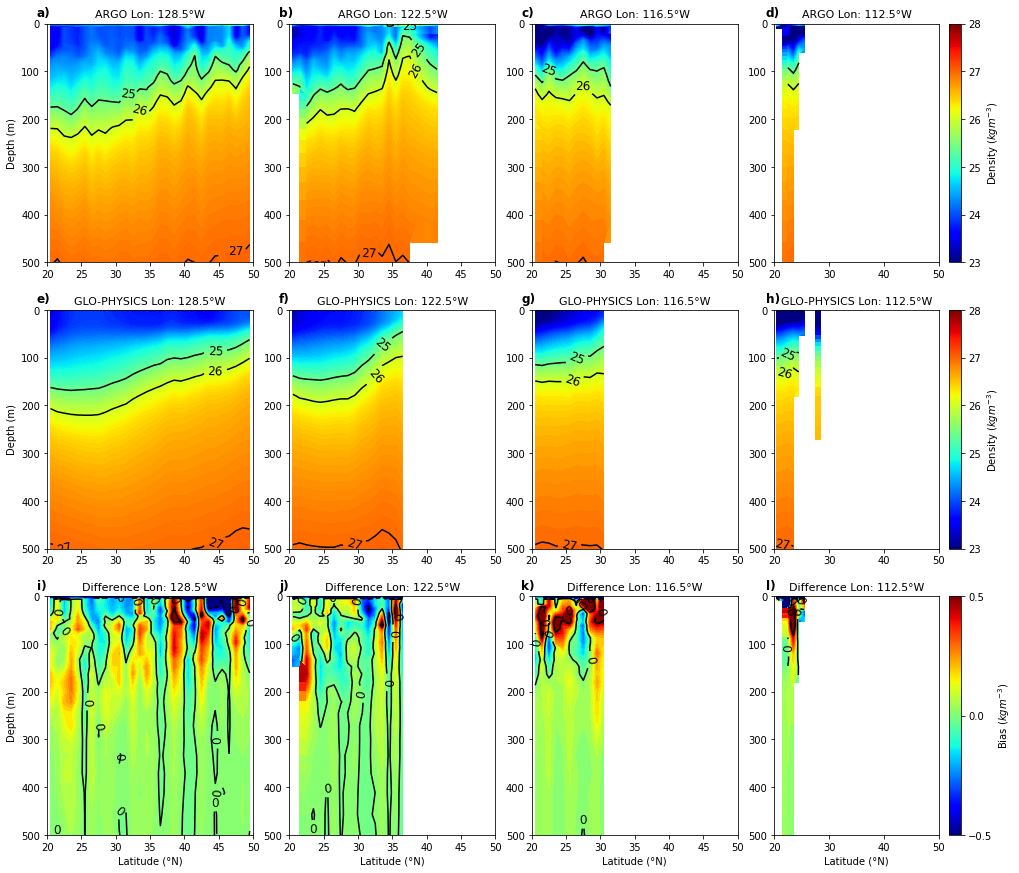

In [105]:
import string
vmins= [23]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [28]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[-0.5,0,0.5]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

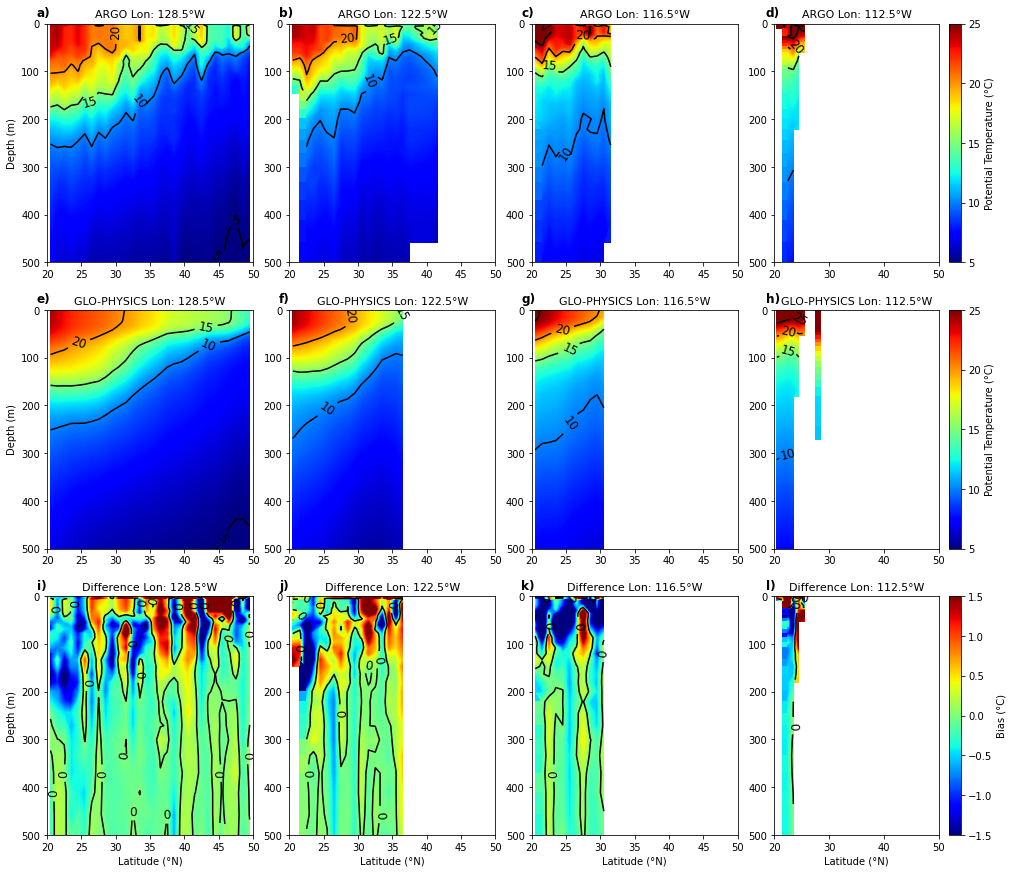

In [106]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=500)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

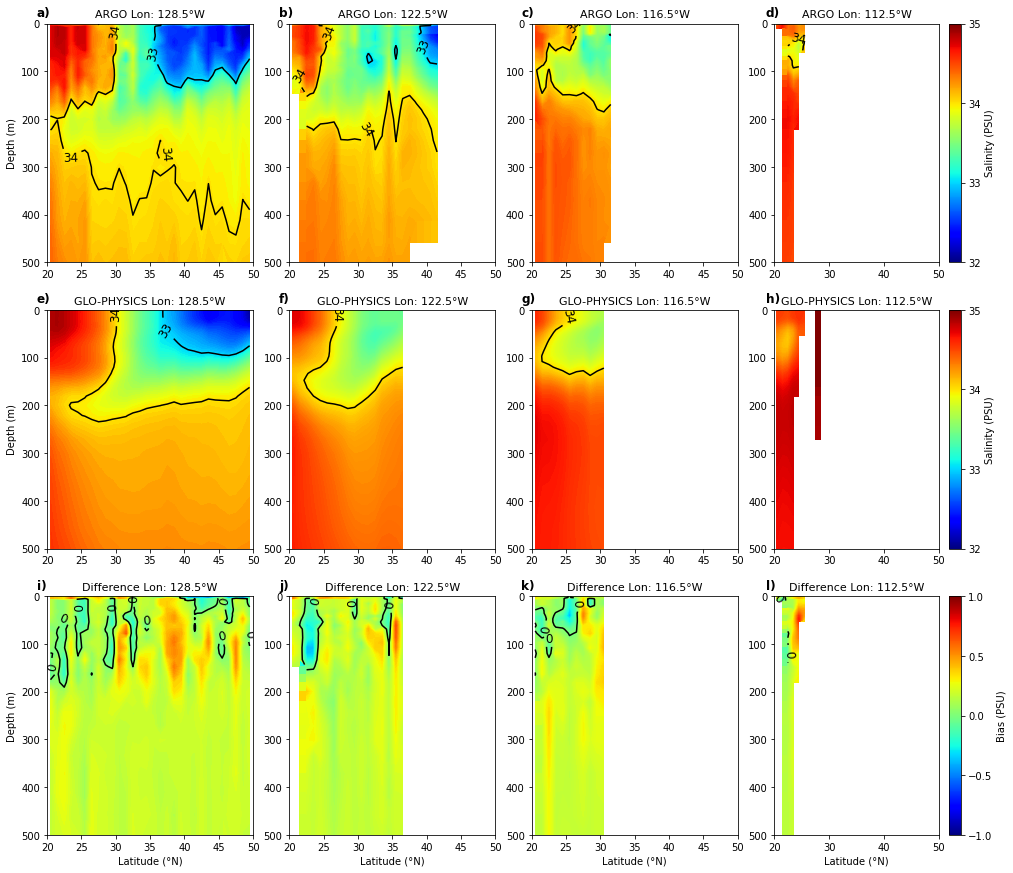

In [107]:
import string
vmins= [32]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [35]*8 + [1]*4 #limites superiores replicados
levelsx=[[33,34,35,36]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 128.5°W','ARGO Lon: 122.5°W','ARGO Lon: 116.5°W','ARGO Lon: 112.5°W',
       'GLO-PHYSICS Lon: 128.5°W','GLO-PHYSICS Lon: 122.5°W','GLO-PHYSICS Lon: 116.5°W','GLO-PHYSICS Lon: 112.5°W',
       'Difference Lon: 128.5°W','Difference Lon: 122.5°W','Difference Lon: 116.5°W','Difference Lon: 112.5°W']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
lista_final_S[0][lista_final_S[0]>35]= 33
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([20,50]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Longitudinales

In [108]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lat_Y= [48.5,40.5,32.5,24.5]
for i in range(4):
  tran_lat_d=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_s=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_t=A_final.sel(lat=lat_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lat=lat_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lat=lat_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lat=lat_Y[i]).T.values
  tran_lat_dx=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_sx=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_tx=A_final.sel(lat=lat_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(tran_lat_M_d);lista_ARGOX_LAT_D.append((M_final.sel(lat=lat_Y[i]).D-A_final.sel(lat=lat_Y[i]).D).values)
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(tran_lat_M_s);lista_ARGOX_LAT_S.append((M_final.sel(lat=lat_Y[i]).S-A_final.sel(lat=lat_Y[i]).S).values)
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(tran_lat_M_t);lista_ARGOX_LAT_T.append((M_final.sel(lat=lat_Y[i]).T-A_final.sel(lat=lat_Y[i]).T).values)
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_D[0][lista_final_D[0]>27.10728928778205]= 27.10728928778205-0.2
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_S[0][lista_final_S[0]>36]= 36-0.4
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

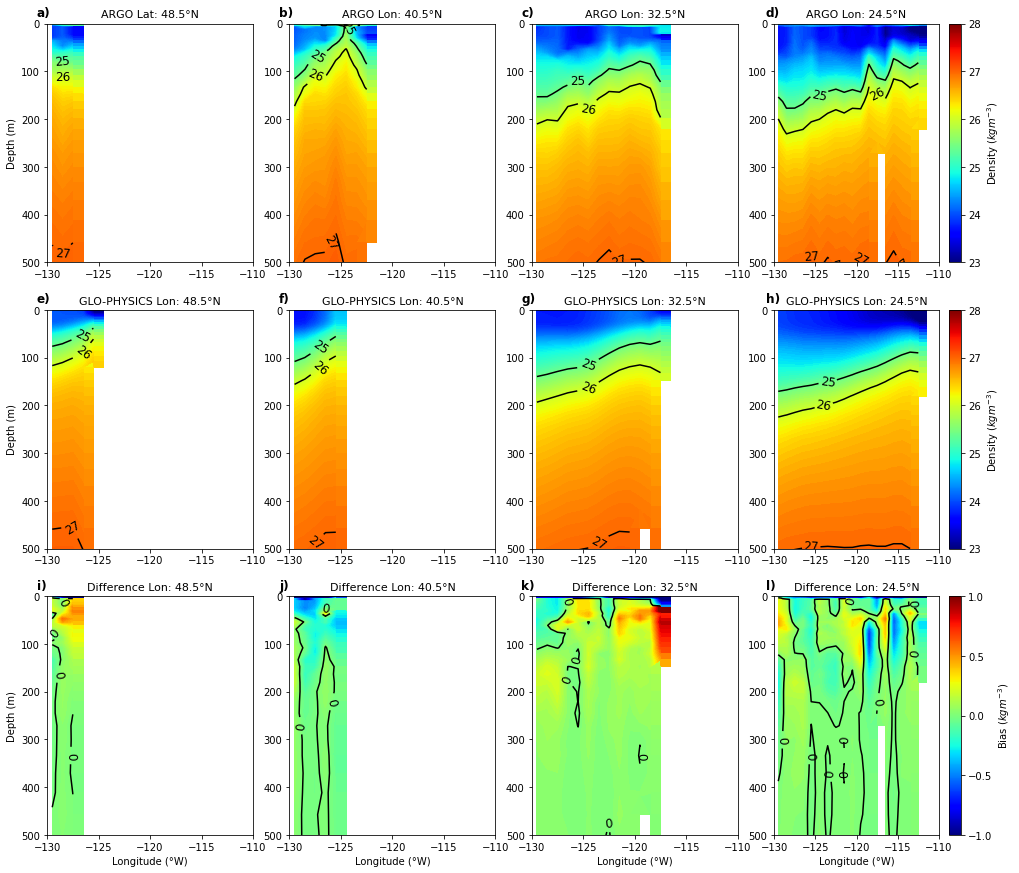

In [109]:
import string
vmins= [23]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [28]*8 + [1]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

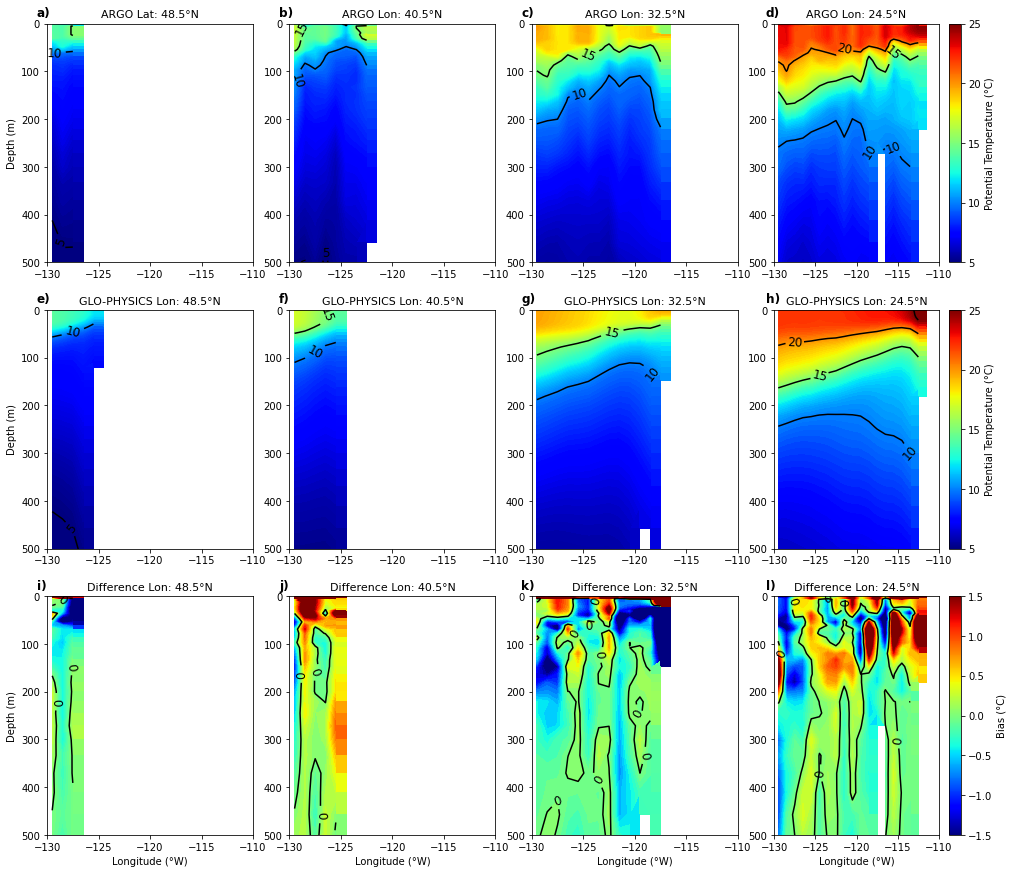

In [110]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

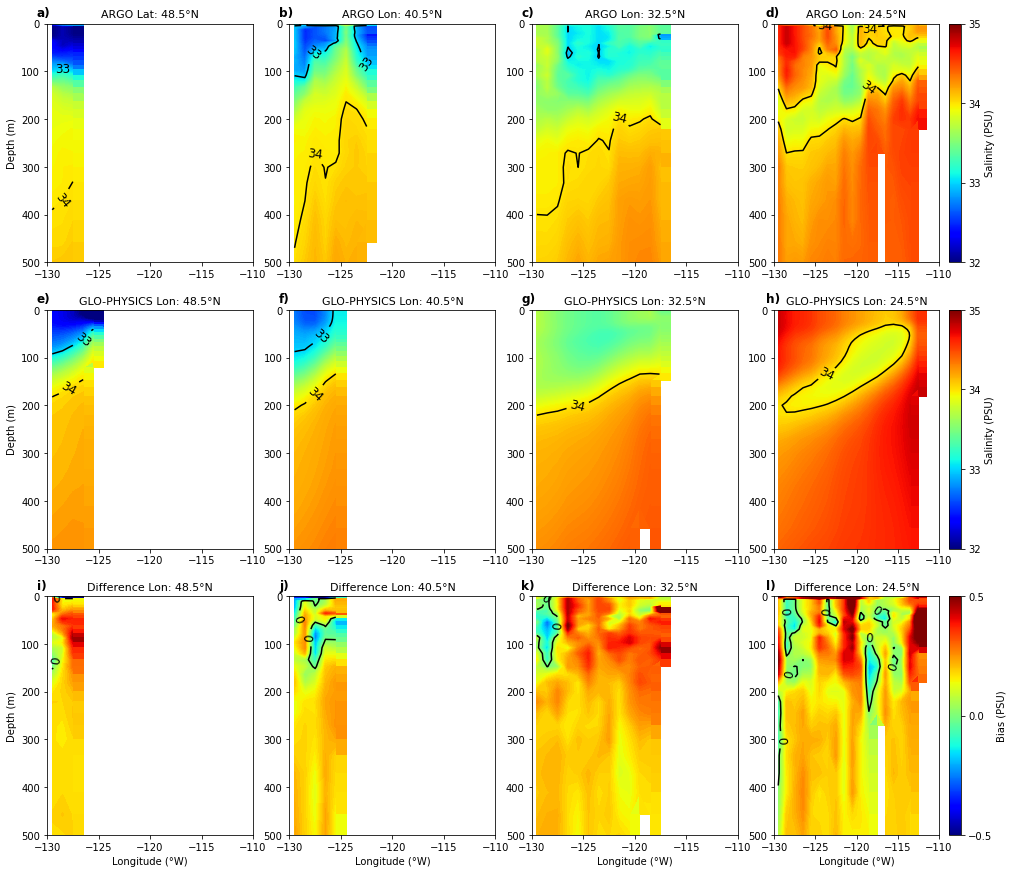

In [111]:
import string
vmins= [32]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [35]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[33,34,35,36]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 48.5°N','ARGO Lon: 40.5°N','ARGO Lon: 32.5°N','ARGO Lon: 24.5°N',
       'GLO-PHYSICS Lon: 48.5°N','GLO-PHYSICS Lon: 40.5°N','GLO-PHYSICS Lon: 32.5°N','GLO-PHYSICS Lon: 24.5°N',
       'Difference Lon: 48.5°N','Difference Lon: 40.5°N','Difference Lon: 32.5°N','Difference Lon: 24.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-130,-110]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Diagramas de Taylor

In [112]:
STD_D=[];CORRCOEF_D=[];RMSE_D=[]
STD_S=[];CORRCOEF_S=[];RMSE_S=[]
STD_T=[];CORRCOEF_T=[];RMSE_T=[]
for i in range(40):
  ###### DEN ######
  modelo= np.flipud(M_final.D.values[i,:,:]).flatten()
  satelite= A_final.D.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_D.append(np.ma.std(P.ravel()))
  CORRCOEF_D.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_D.append(np.sqrt(np.mean((P-A)**2)))
  ###### SAL ######
  modelo= np.flipud(M_final.S.values[i,:,:]).flatten()
  satelite= A_final.S.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_S.append(np.ma.std(P.ravel()))
  CORRCOEF_S.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_S.append(np.sqrt(np.mean((P-A)**2)))
  ###### TEMP ######
  modelo= np.flipud(M_final.T.values[i,:,:]).flatten()
  satelite= A_final.T.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_T.append(np.ma.std(P.ravel()))
  CORRCOEF_T.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_T.append(np.sqrt(np.mean((P-A)**2)))

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

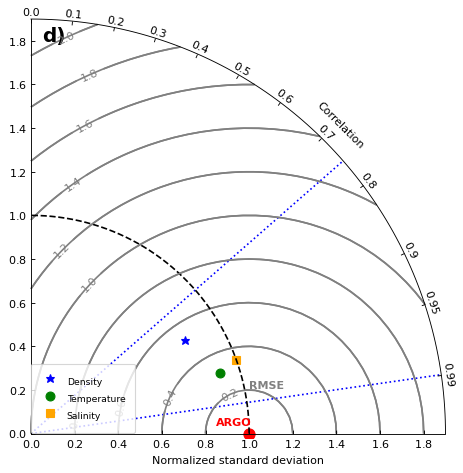

In [113]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0., 1.9), label='ARGO')
pp=[]
ttt=TayDia.add_sample(np.mean(STD_D), np.mean(CORRCOEF_D)+0.05, marker="*", linestyle='None', color='blue', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_T), np.mean(CORRCOEF_T), marker="o", linestyle='None', color='green', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_S), np.mean(CORRCOEF_S), marker="s", linestyle='None', color='orange', ms=8);pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -1.25**2)],[0,1.25], color='blue',linestyle=':') # correlacion 0.75
plt.plot([0,NP.sqrt(1.9**2 -0.27**2)],[0,0.27], color='blue',linestyle=':') # correlacion 0.99
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, ['Density','Temperature','Salinity'],  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'ARGO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'d)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')